# Understanding Hired Rides in NYC


## Project Setup

In [1]:
## Load all packages
import math
import numpy as np
import os
import re
import requests
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import geopandas as gpd
from sqlalchemy import create_engine
from sqlalchemy import text
from datetime import datetime
from scipy.stats import norm
import folium
from folium.plugins import HeatMap
import seaborn as sns
from matplotlib.animation import FuncAnimation

In [93]:
TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

shapefile_path = 'taxi_zones/taxi_zones.shp'
zones_gdf = gpd.read_file(shapefile_path)
zones_gdf = zones_gdf.to_crs(epsg=4326) 
zones_gdf['centroid'] = zones_gdf.geometry.centroid
zones_gdf['latitude'] = zones_gdf['centroid'].y
zones_gdf['longitude'] = zones_gdf['centroid'].x
zones_df = zones_gdf[['LocationID', 'latitude', 'longitude']]

# location constraints 
LAT_MIN, LAT_MAX = 40.560445, 40.908524
LON_MIN, LON_MAX = -74.242330, -73.717047

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

/var/folders/11/lc3ysjsj6qxbf1dzv2_sr04h0000gn/T/ipykernel_55266/2626791839.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_gdf['centroid'] = zones_gdf.geometry.centroid


In [3]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Programmatically downloaded the Yellow Taxi & High-Volume For-Hire Vehicle (HVFHV)

In [4]:
def download_taxi_data(output_dir="data_parquet"):
    url_template = "https://d37ci6vzurychx.cloudfront.net/trip-data/{type}_tripdata_{year}-{month:02d}.parquet"
    
    # Regex pattern 
    pattern = re.compile(r"(yellow|fhvhv)_tripdata_(202[0-4])-(0[1-9]|1[0-2])\.parquet")   
    os.makedirs(output_dir, exist_ok=True)

    for year in range(2020, 2025):  # Loop through years 2020 to 2024
        for month in range(1, 13):  # Loop through months 1 to 12
            if year == 2024 and month > 8:
                break
            for taxi_type in ["yellow", "fhvhv"]: 
                url = url_template.format(type=taxi_type, year=year, month=month)
                if pattern.match(url.split("/")[-1]):
                    file_prefix = "Yellow_Taxi" if taxi_type == "yellow" else "HVFHV_Taxi"
                    local_filename = f"{file_prefix}_{year}-{month:02d}.parquet"
                    local_filepath = os.path.join(output_dir, local_filename)

                    response = requests.get(url, stream=True)
                    if response.status_code == 200:
                        with open(local_filepath, "wb") as file:
                            for chunk in response.iter_content(chunk_size=1024):
                                file.write(chunk)
                        print(f"Downloaded: {local_filename}")
                    else:
                        print(f"Failed to download: {url}, Status code: {response.status_code}")
                else:
                    print(f"Invalid URL format: {url}")

download_taxi_data()

Downloaded: Yellow_Taxi_2020-01.parquet
Downloaded: HVFHV_Taxi_2020-01.parquet
Downloaded: Yellow_Taxi_2020-02.parquet
Downloaded: HVFHV_Taxi_2020-02.parquet
Downloaded: Yellow_Taxi_2020-03.parquet
Downloaded: HVFHV_Taxi_2020-03.parquet
Downloaded: Yellow_Taxi_2020-04.parquet
Downloaded: HVFHV_Taxi_2020-04.parquet
Downloaded: Yellow_Taxi_2020-05.parquet
Downloaded: HVFHV_Taxi_2020-05.parquet
Downloaded: Yellow_Taxi_2020-06.parquet
Downloaded: HVFHV_Taxi_2020-06.parquet
Downloaded: Yellow_Taxi_2020-07.parquet
Downloaded: HVFHV_Taxi_2020-07.parquet
Downloaded: Yellow_Taxi_2020-08.parquet
Downloaded: HVFHV_Taxi_2020-08.parquet
Downloaded: Yellow_Taxi_2020-09.parquet
Downloaded: HVFHV_Taxi_2020-09.parquet
Downloaded: Yellow_Taxi_2020-10.parquet
Downloaded: HVFHV_Taxi_2020-10.parquet
Downloaded: Yellow_Taxi_2020-11.parquet
Downloaded: HVFHV_Taxi_2020-11.parquet
Downloaded: Yellow_Taxi_2020-12.parquet
Downloaded: HVFHV_Taxi_2020-12.parquet
Downloaded: Yellow_Taxi_2021-01.parquet
Downloaded: 

In [5]:
# check sample uber data
data_uber_sample_1 = pd.read_parquet("data_parquet/HVFHV_Taxi_2020-01.parquet")
data_uber_sample_1

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02864,B02864,2020-01-01 00:40:13,2020-01-01 00:43:34,2020-01-01 00:45:34,2020-01-01 01:02:20,148,90,1.93,...,2.70,2.75,NaN,0.0,18.25,N,N,,N,N
1,HV0003,B02682,B02682,2020-01-01 00:42:31,2020-01-01 00:46:33,2020-01-01 00:47:50,2020-01-01 00:53:23,114,79,0.81,...,1.31,2.75,NaN,0.0,10.84,N,N,,N,N
2,HV0003,B02764,B02764,2020-01-01 00:01:42,2020-01-01 00:02:06,2020-01-01 00:04:37,2020-01-01 00:21:49,4,125,2.53,...,1.39,2.75,NaN,3.0,11.73,N,N,,N,N
3,HV0003,B02764,B02764,2020-01-01 00:21:23,2020-01-01 00:26:02,2020-01-01 00:26:36,2020-01-01 00:33:00,231,113,1.11,...,0.75,2.75,NaN,0.0,5.84,N,N,,N,N
4,HV0003,B02764,B02764,2020-01-01 00:32:20,2020-01-01 00:37:06,2020-01-01 00:37:49,2020-01-01 00:46:59,114,144,1.10,...,1.03,2.75,NaN,0.0,7.69,N,N,,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20569363,HV0005,B02510,None,2020-01-31 23:27:10,NaT,2020-01-31 23:32:57,2020-01-31 23:39:09,132,10,2.73,...,0.91,0.00,NaN,0.0,0.00,Y,N,N,N,N
20569364,HV0003,B02764,B02764,2020-01-31 23:23:50,2020-01-31 23:27:46,2020-01-31 23:29:14,2020-01-31 23:57:17,48,148,4.95,...,1.66,2.75,NaN,0.0,19.30,N,N,,N,N
20569365,HV0003,B02395,B02395,2020-01-31 22:57:49,2020-01-31 22:58:23,2020-01-31 23:01:04,2020-01-31 23:15:42,152,159,2.78,...,0.00,0.00,NaN,0.0,10.29,N,N,,N,N
20569366,HV0003,B02395,B02395,2020-01-31 23:14:16,2020-01-31 23:15:42,2020-01-31 23:17:42,2020-01-31 23:51:42,159,191,16.69,...,0.00,0.00,NaN,0.0,35.11,N,N,,N,N


In [6]:
# check sample yellow taxi data
data_yellow_sample_1 = pd.read_parquet("data_parquet/Yellow_Taxi_2022-05.parquet")
data_yellow_sample_1

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,4.10,1.0,N,246,151,2,17.00,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,2.30,1.0,N,238,74,2,11.00,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,4.20,1.0,N,163,260,2,15.50,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0
3,1,2022-05-01 00:48:18,2022-05-01 01:28:02,1.0,0.00,1.0,N,79,182,1,41.20,0.0,0.5,0.00,0.0,0.3,42.00,0.0,0.0
4,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.0,1.60,1.0,N,238,75,1,7.50,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588290,2,2022-05-31 23:40:19,2022-06-01 00:01:20,NaN,0.00,NaN,None,36,181,0,20.97,0.0,0.5,1.00,0.0,0.3,22.77,NaN,NaN
3588291,2,2022-05-31 23:52:12,2022-06-01 00:06:40,NaN,2.91,NaN,None,144,256,0,11.68,0.0,0.0,2.51,0.0,0.3,16.99,NaN,NaN
3588292,2,2022-05-31 23:27:00,2022-05-31 23:48:00,NaN,3.96,NaN,None,161,145,0,14.54,0.0,0.5,0.00,0.0,0.3,17.84,NaN,NaN
3588293,2,2022-05-31 23:34:12,2022-06-01 00:00:13,NaN,6.27,NaN,None,145,17,0,24.01,0.0,0.5,5.54,0.0,0.3,30.35,NaN,NaN


### Calculate Sample Size

In [7]:
def calculate_sample_size(population_size, confidence_level=0.95, margin_of_error=0.05, proportion=0.5):
    z_scores = {0.90: 1.645, 0.95: 1.96, 0.99: 2.576}
    z = z_scores.get(confidence_level, 1.96)  # choose 1.96
    n0 = (z**2 * proportion * (1 - proportion)) / (margin_of_error**2)
    
    if population_size > 0 and population_size < math.inf:
        n = n0 / (1 + (n0 - 1) / population_size)
    else:
        n = n0
    return min(math.ceil(n), population_size) 

In [9]:
# Sampling function for Uber rides
def sample_uber_data(input_path, output_path, confidence_level=0.90, margin_of_error=0.10):
    try:
        df = pd.read_parquet(input_path)
        # Filter only Uber rides with 'HV0003'
        df = df[df['hvfhs_license_num'] == 'HV0003']
        population_size = len(df)

        if population_size == 0:
            print(f"No valid data found in {input_path} after filtering for 'HV0003'. Skipping.")
            return
        
        # Calculate sample size
        sample_size = calculate_sample_size(population_size, confidence_level, margin_of_error)
        print(f"Uber Dataset: Population size = {population_size}, Sample size = {sample_size}")
        
        sampled_df = df.sample(n=sample_size, random_state=42)
        
        sampled_df.to_parquet(output_path, index=False)
        print(f"Sampled Uber data saved to: {output_path}")
    except Exception as e:
        print(f"Error processing Uber data from {input_path}: {e}")

# Process all Uber files in a directory
def process_uber_files(input_dir, output_dir, confidence_level=0.90, margin_of_error=0.10):
    """
    Process all Uber files in the input directory, filter, sample, and save results to the output directory.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for file_name in os.listdir(input_dir):
        if file_name.startswith("HVFHV_Taxi") and file_name.endswith(".parquet"):
            input_path = os.path.join(input_dir, file_name)
            output_path = os.path.join(output_dir, f"Sampled_{file_name}")
            print(f"Processing file: {file_name}")
            sample_uber_data(input_path, output_path, confidence_level, margin_of_error)

In [10]:
input_directory = "data_parquet"  
uber_output_directory = "sampled_data" 
process_uber_files(input_directory, uber_output_directory, confidence_level=0.95, margin_of_error=0.05)

Processing file: HVFHV_Taxi_2020-03.parquet
Uber Dataset: Population size = 9836781, Sample size = 385
Sampled Uber data saved to: sampled_data/Sampled_HVFHV_Taxi_2020-03.parquet
Processing file: HVFHV_Taxi_2022-09.parquet
Uber Dataset: Population size = 12902315, Sample size = 385
Sampled Uber data saved to: sampled_data/Sampled_HVFHV_Taxi_2022-09.parquet
Processing file: HVFHV_Taxi_2021-05.parquet
Uber Dataset: Population size = 10808415, Sample size = 385
Sampled Uber data saved to: sampled_data/Sampled_HVFHV_Taxi_2021-05.parquet
Processing file: HVFHV_Taxi_2024-04.parquet
Uber Dataset: Population size = 14704197, Sample size = 385
Sampled Uber data saved to: sampled_data/Sampled_HVFHV_Taxi_2024-04.parquet
Processing file: HVFHV_Taxi_2023-06.parquet
Uber Dataset: Population size = 13811993, Sample size = 385
Sampled Uber data saved to: sampled_data/Sampled_HVFHV_Taxi_2023-06.parquet
Processing file: HVFHV_Taxi_2022-10.parquet
Uber Dataset: Population size = 14102892, Sample size = 3

In [11]:
# Sampling function for Yellow Taxi data
def sample_yellow_taxi_data(input_path, output_path, confidence_level=0.95, margin_of_error=0.05):
    try:
        df = pd.read_parquet(input_path)
        
        # Calculate sample size
        population_size = len(df)
        if population_size == 0:
            print(f"No data found in {input_path}. Skipping.")
            return
        
        sample_size = calculate_sample_size(population_size, confidence_level, margin_of_error)
        print(f"Yellow Taxi Dataset: Population size = {population_size}, Sample size = {sample_size}")
        
        sampled_df = df.sample(n=sample_size, random_state=42)
        
        # Save the sampled data
        sampled_df.to_parquet(output_path, index=False)
        print(f"Sampled Yellow Taxi data saved to: {output_path}")
    except Exception as e:
        print(f"Error processing Yellow Taxi data from {input_path}: {e}")

# Process all Yellow Taxi files in a directory
def process_yellow_taxi_files(input_dir, output_dir, confidence_level=0.95, margin_of_error=0.05):
    """
    Process all Yellow Taxi files in the input directory, sample, and save results to the output directory.
    """
    os.makedirs(output_dir, exist_ok=True)  
    
    for file_name in os.listdir(input_dir):
        if file_name.startswith("Yellow_Taxi") and file_name.endswith(".parquet"): 
            input_path = os.path.join(input_dir, file_name)
            output_path = os.path.join(output_dir, f"Sampled_{file_name}")
            print(f"Processing file: {file_name}")
            sample_yellow_taxi_data(input_path, output_path, confidence_level, margin_of_error)

In [12]:
input_directory = "data_parquet"  
uber_output_directory = "sampled_data"  
process_yellow_taxi_files(input_dir=input_directory, output_dir=uber_output_directory, confidence_level=0.95, margin_of_error=0.05)

Processing file: Yellow_Taxi_2020-01.parquet
Yellow Taxi Dataset: Population size = 6405008, Sample size = 385
Sampled Yellow Taxi data saved to: sampled_data/Sampled_Yellow_Taxi_2020-01.parquet
Processing file: Yellow_Taxi_2020-11.parquet
Yellow Taxi Dataset: Population size = 1509000, Sample size = 385
Sampled Yellow Taxi data saved to: sampled_data/Sampled_Yellow_Taxi_2020-11.parquet
Processing file: Yellow_Taxi_2021-07.parquet
Yellow Taxi Dataset: Population size = 2821746, Sample size = 385
Sampled Yellow Taxi data saved to: sampled_data/Sampled_Yellow_Taxi_2021-07.parquet
Processing file: Yellow_Taxi_2024-06.parquet
Yellow Taxi Dataset: Population size = 3539193, Sample size = 385
Sampled Yellow Taxi data saved to: sampled_data/Sampled_Yellow_Taxi_2024-06.parquet
Processing file: Yellow_Taxi_2020-08.parquet
Yellow Taxi Dataset: Population size = 1007286, Sample size = 385
Sampled Yellow Taxi data saved to: sampled_data/Sampled_Yellow_Taxi_2020-08.parquet
Processing file: Yellow_T

In [13]:
# View the sample yellow taxi dataset
data_yellow_sample = pd.read_parquet("sampled_data/Sampled_Yellow_Taxi_2022-06.parquet")
data_yellow_sample

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2022-06-17 14:44:27,2022-06-17 15:47:52,1.0,15.20,1.0,N,132,106,1,53.0,0.00,0.5,8.00,0.00,0.3,63.05,0.0,1.25
1,1,2022-06-26 12:21:46,2022-06-26 12:54:11,2.0,13.60,1.0,N,138,13,1,38.0,3.75,0.5,0.05,0.00,0.3,42.60,2.5,1.25
2,2,2022-06-17 17:15:43,2022-06-17 17:23:42,1.0,1.44,1.0,N,229,140,2,7.0,1.00,0.5,0.00,0.00,0.3,11.30,2.5,0.00
3,2,2022-06-08 15:54:50,2022-06-08 15:58:59,1.0,0.39,1.0,N,107,137,2,4.5,0.00,0.5,0.00,0.00,0.3,7.80,2.5,0.00
4,2,2022-06-20 22:11:05,2022-06-20 22:22:52,1.0,3.99,1.0,N,138,129,1,14.0,0.50,0.5,3.06,0.00,0.3,19.61,0.0,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,2,2022-06-15 04:57:36,2022-06-15 05:17:34,1.0,10.13,1.0,N,163,138,2,29.0,0.50,0.5,0.00,6.55,0.3,39.35,2.5,0.00
381,2,2022-06-23 09:22:36,2022-06-23 09:38:12,1.0,1.28,1.0,N,50,161,1,10.5,0.00,0.5,0.00,0.00,0.3,13.80,2.5,0.00
382,2,2022-06-25 16:24:51,2022-06-25 16:27:29,2.0,0.69,1.0,N,164,234,1,4.5,0.00,0.5,1.00,0.00,0.3,8.80,2.5,0.00
383,2,2022-06-11 12:45:36,2022-06-11 13:14:55,4.0,5.03,1.0,N,236,68,1,21.5,0.00,0.5,4.96,0.00,0.3,29.76,2.5,0.00


In [14]:
# View sample Uber dataset
data_uber_sample = pd.read_parquet("sampled_data/Sampled_HVFHV_Taxi_2023-12.parquet")
data_uber_sample

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2023-12-28 09:43:16,2023-12-28 09:44:26,2023-12-28 09:44:39,2023-12-28 10:04:51,157,65,7.39,...,2.86,0.00,0.0,0.0,23.97,N,N,N,N,Y
1,HV0003,B03404,B03404,2023-12-06 14:12:54,2023-12-06 14:16:09,2023-12-06 14:17:05,2023-12-06 14:26:51,228,228,1.54,...,1.03,0.00,0.0,0.0,7.53,N,N,N,N,N
2,HV0003,B03404,B03404,2023-12-01 00:02:41,2023-12-01 00:09:47,2023-12-01 00:11:49,2023-12-01 00:35:39,138,48,9.73,...,5.36,2.75,2.5,0.0,26.74,N,N,N,N,N
3,HV0003,B03404,B03404,2023-12-12 19:10:03,2023-12-12 19:14:29,2023-12-12 19:14:29,2023-12-12 19:43:22,91,76,6.36,...,2.78,0.00,0.0,0.0,24.65,N,N,N,N,N
4,HV0003,B03404,B03404,2023-12-02 06:57:43,2023-12-02 07:02:35,2023-12-02 07:02:40,2023-12-02 07:44:08,142,265,30.26,...,9.19,2.75,0.0,0.0,72.01,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,HV0003,B03404,B03404,2023-12-06 06:22:15,2023-12-06 06:25:18,2023-12-06 06:25:39,2023-12-06 06:40:46,226,193,2.90,...,1.58,0.00,0.0,0.0,13.34,N,N,N,N,N
381,HV0003,B03404,B03404,2023-12-31 14:04:25,2023-12-31 14:04:34,2023-12-31 14:05:22,2023-12-31 14:16:44,256,17,1.50,...,0.95,0.00,0.0,5.0,8.38,N,N,N,N,N
382,HV0003,B03404,B03404,2023-12-17 14:16:11,2023-12-17 14:18:19,2023-12-17 14:18:40,2023-12-17 14:28:18,129,7,1.79,...,1.02,0.00,0.0,0.0,10.77,N,N,N,N,Y
383,HV0003,B03404,B03404,2023-12-13 17:50:32,2023-12-13 17:52:10,2023-12-13 17:52:24,2023-12-13 18:09:13,145,226,2.11,...,1.26,0.00,0.0,0.0,12.26,N,N,N,N,N


### Process Yellow Taxi Data

In [15]:
def process_taxi_data(data_path, zones_df):
    taxi_data = pd.read_parquet(data_path)
    print(f"Processing file: {data_path}")

    # Merge with pickup LocationID
    taxi_data = taxi_data.merge(
        zones_df, how="left", left_on="PULocationID", right_on="LocationID"
    ).rename(columns={"latitude": "pickup_latitude", "longitude": "pickup_longitude"})

    # Merge with dropoff LocationID
    taxi_data = taxi_data.merge(
        zones_df, how="left", left_on="DOLocationID", right_on="LocationID", suffixes=("", "_dropoff")
    ).rename(columns={"latitude": "dropoff_latitude", "longitude": "dropoff_longitude"})

    # Drop rows with missing pickup/dropoff coordinates
    taxi_data = taxi_data.dropna(subset=["pickup_latitude", "dropoff_latitude"])

    # Filter trips within the coordinate limit
    taxi_data = taxi_data[
        (taxi_data["pickup_latitude"].between(LAT_MIN, LAT_MAX)) &
        (taxi_data["pickup_longitude"].between(LON_MIN, LON_MAX)) &
        (taxi_data["dropoff_latitude"].between(LAT_MIN, LAT_MAX)) &
        (taxi_data["dropoff_longitude"].between(LON_MIN, LON_MAX))
    ]

    # Change datetime type and rename columns
    taxi_data.rename(
        columns={"tpep_pickup_datetime": "pickup_datetime", "tpep_dropoff_datetime": "dropoff_datetime"},
        inplace=True,
        errors="ignore"
    )

    # Keep only the required columns
    required_columns = [
        "pickup_datetime", "dropoff_datetime", "pickup_latitude", "pickup_longitude",
        "dropoff_latitude", "dropoff_longitude", "passenger_count", "trip_distance",
        "fare_amount", "tip_amount", "tolls_amount", "mta_tax", "total_amount", "congestion_surcharge"
    ]
    taxi_data = taxi_data[[col for col in required_columns if col in taxi_data.columns]]

    print("Before filtering:")
    print(taxi_data.describe(include="all"))

    taxi_data = taxi_data[
        (taxi_data['trip_distance'] > 0) &
        (taxi_data['fare_amount'] > 0) &
        (taxi_data['passenger_count'] > 0) &
        (taxi_data['total_amount'] > 0)  
    ]

    print("After filtering:")
    print(taxi_data.describe(include="all"))

    # Normalize column names
    taxi_data.columns = taxi_data.columns.str.lower().str.strip()

    return taxi_data


def process_all_yellow_taxi_files(input_dir, output_dir, zones_df):
    os.makedirs(output_dir, exist_ok=True)
    combined_data = pd.DataFrame()

    for file_name in os.listdir(input_dir):
        if file_name.startswith("Sampled_Yellow_Taxi") and file_name.endswith(".parquet"):
            input_path = os.path.join(input_dir, file_name)
            output_path = os.path.join(output_dir, f"Processed_{file_name}")

            processed_data = process_taxi_data(input_path, zones_df)
            if not processed_data.empty:
                processed_data.to_parquet(output_path, index=False)
                print(f"Processed file saved to: {output_path}")
                combined_data = pd.concat([combined_data, processed_data], axis=0)

    combined_output_path = os.path.join(output_dir, "Combined_Yellow_Taxi.parquet")
    if not combined_data.empty:
        combined_data.to_parquet(combined_output_path, index=False)
        print(f"Combined data saved to: {combined_output_path}")
    else:
        print("No valid data to combine.")


In [16]:
input_directory = "sampled_data"  
output_directory = "processed_yellow_taxi"  
process_all_yellow_taxi_files(input_directory, output_directory, zones_df)

Processing file: sampled_data/Sampled_Yellow_Taxi_2020-01.parquet
Before filtering:
                  pickup_datetime            dropoff_datetime  \
count                         377                         377   
mean   2020-01-17 13:07:25.862069  2020-01-17 13:20:19.228116   
min           2020-01-01 00:11:06         2020-01-01 00:30:50   
25%           2020-01-09 20:20:30         2020-01-09 20:26:07   
50%           2020-01-18 03:47:42         2020-01-18 03:55:44   
75%           2020-01-25 07:19:05         2020-01-25 07:26:52   
max           2020-01-31 21:28:53         2020-01-31 21:36:09   
std                           NaN                         NaN   

       pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude  \
count       377.000000        377.000000        377.000000         377.000000   
mean         40.749711        -73.966632         40.752385         -73.974183   
min          40.646985        -74.013023         40.604914         -74.174000   
25%   

In [17]:
# load all yellow_taxi data 
combined_yellow_taxi_path = "processed_yellow_taxi/Combined_Yellow_Taxi.parquet"
taxi_data = pd.read_parquet(combined_yellow_taxi_path)

In [18]:
taxi_data.head()

,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,mta_tax,total_amount,congestion_surcharge
0,2020-01-25 10:49:58,2020-01-25 11:07:35,40.773633,-73.981532,40.753309,-74.004015,1.0,3.28,14.0,1.70,0.0,0.5,19.00,2.5
1,2020-01-15 07:30:08,2020-01-15 07:40:01,40.791705,-73.973049,40.809457,-73.961764,1.0,1.75,8.5,1.20,0.0,0.5,13.00,2.5
2,2020-01-09 06:29:09,2020-01-09 06:35:44,40.753513,-73.988787,40.748575,-73.985156,1.0,0.87,5.5,0.00,0.0,0.5,8.80,2.5
3,2020-01-26 12:24:04,2020-01-26 12:29:15,40.758028,-73.977698,40.782478,-73.965554,2.0,0.98,5.5,0.00,0.0,0.5,8.80,2.5
4,2020-01-30 07:57:53,2020-01-30 08:10:19,40.756729,-73.965146,40.775932,-73.946510,1.0,1.30,9.0,2.45,0.0,0.5,14.75,2.5


In [19]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19296 entries, 0 to 19295
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   pickup_datetime       19296 non-null  datetime64[us]
 1   dropoff_datetime      19296 non-null  datetime64[us]
 2   pickup_latitude       19296 non-null  float64       
 3   pickup_longitude      19296 non-null  float64       
 4   dropoff_latitude      19296 non-null  float64       
 5   dropoff_longitude     19296 non-null  float64       
 6   passenger_count       19296 non-null  float64       
 7   trip_distance         19296 non-null  float64       
 8   fare_amount           19296 non-null  float64       
 9   tip_amount            19296 non-null  float64       
 10  tolls_amount          19296 non-null  float64       
 11  mta_tax               19296 non-null  float64       
 12  total_amount          19296 non-null  float64       
 13  congestion_surch

In [20]:
taxi_data.describe()

,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,mta_tax,total_amount,congestion_surcharge
count,19296,19296,19296.000000,19296.000000,19296.000000,19296.000000,19296.000000,19296.000000,19296.000000,19296.000000,19296.000000,19296.000000,19296.000000,19296.000000
mean,2022-05-01 09:21:38.161536,2022-05-01 09:37:32.471600,40.753621,-73.967275,40.756134,-73.971708,1.431177,3.177432,15.001851,2.741091,0.420006,0.497875,22.202341,2.329110
min,2020-01-01 00:11:06,2020-01-01 00:30:50,40.576961,-74.029892,40.576961,-74.174000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,1.300000,0.000000
25%,2021-03-09 21:41:56.250000,2021-03-09 21:50:09,40.740439,-73.989845,40.740337,-73.989845,1.000000,1.060000,7.200000,0.000000,0.000000,0.500000,12.600000,2.500000
50%,2022-05-03 12:09:18.500000,2022-05-03 12:49:19.500000,40.758028,-73.977698,40.758028,-73.977698,1.000000,1.770000,10.500000,2.160000,0.000000,0.500000,16.635000,2.500000
75%,2023-06-22 13:08:33,2023-06-22 13:37:12,40.773633,-73.965146,40.775932,-73.959635,1.000000,3.200000,16.500000,3.460000,0.000000,0.500000,23.880000,2.500000
max,2024-08-31 22:43:47,2024-08-31 23:26:23,40.899529,-73.739337,40.899529,-73.726655,6.000000,67.900000,209.500000,50.000000,40.000000,0.500000,262.700000,2.500000
std,NaN,NaN,0.031061,0.044985,0.031498,0.034578,0.977291,4.052641,13.526807,3.189875,1.764530,0.032526,17.414175,0.630906


### Process Uber Data

In [21]:
def process_uber_data(data_path, output_path, zones_df):
    uber_data = pd.read_parquet(data_path)
    print(f"Processing file: {data_path}")

    # Merge with pickup LocationID
    uber_data = uber_data.merge(
        zones_df, how="left", left_on="PULocationID", right_on="LocationID"
    ).rename(columns={"latitude": "pickup_latitude", "longitude": "pickup_longitude"})

    # Merge with dropoff LocationID
    uber_data = uber_data.merge(
        zones_df, how="left", left_on="DOLocationID", right_on="LocationID", suffixes=("", "_dropoff")
    ).rename(columns={"latitude": "dropoff_latitude", "longitude": "dropoff_longitude"})

    # Drop rows with missing pickup/dropoff coordinates
    uber_data = uber_data.dropna(subset=["pickup_latitude", "dropoff_latitude"])

    # Filter trips within the coordinate limit
    uber_data = uber_data[
        (uber_data["pickup_latitude"].between(LAT_MIN, LAT_MAX)) &
        (uber_data["pickup_longitude"].between(LON_MIN, LON_MAX)) &
        (uber_data["dropoff_latitude"].between(LAT_MIN, LAT_MAX)) &
        (uber_data["dropoff_longitude"].between(LON_MIN, LON_MAX))
    ]

    # Keep only the required columns
    required_columns = [
        "pickup_datetime", "dropoff_datetime", "pickup_latitude", "pickup_longitude",
        "dropoff_latitude", "dropoff_longitude", "trip_miles", "tips", "trip_time",
        "base_passenger_fare", "tolls", "sales_tax", "congestion_surcharge"
    ]
    uber_data = uber_data[[col for col in required_columns if col in uber_data.columns]]

    print("Before filtering:")
    print(uber_data.describe(include="all"))

    uber_data = uber_data[
        (uber_data['trip_miles'] > 0) &  # Remove rows with non-positive trip distances
        (uber_data['trip_time'] > 0) &  # Remove rows with non-positive trip times
        (uber_data['base_passenger_fare'] > 0)  # Ensure valid fare values
    ]

    print("After filtering:")
    print(uber_data.describe(include="all"))

    # Normalize column names
    uber_data.columns = uber_data.columns.str.lower().str.strip()

    # Normalize datetime columns
    if 'pickup_datetime' in uber_data.columns:
        uber_data['pickup_datetime'] = pd.to_datetime(uber_data['pickup_datetime'], errors='coerce')
    if 'dropoff_datetime' in uber_data.columns:
        uber_data['dropoff_datetime'] = pd.to_datetime(uber_data['dropoff_datetime'], errors='coerce')

    # Drop rows with invalid datetime values (if any)
    uber_data = uber_data.dropna(subset=['pickup_datetime', 'dropoff_datetime'])

    if not uber_data.empty:
        uber_data.to_parquet(output_path, index=False)
        print(f"Filtered data saved to: {output_path}")
    else:
        print(f"No valid data to save for: {data_path}")

    return uber_data


# Process and combine all Uber files
def process_and_combine_uber_files(input_dir, output_dir, zones_df):
    os.makedirs(output_dir, exist_ok=True)
    combined_data = pd.DataFrame()

    for file_name in os.listdir(input_dir):
        if file_name.startswith("Sampled_HVFHV_Taxi") and file_name.endswith(".parquet"):
            input_path = os.path.join(input_dir, file_name)
            output_path = os.path.join(output_dir, f"Processed_{file_name}")

            processed_data = process_uber_data(input_path, output_path, zones_df)
            if not processed_data.empty:
                combined_data = pd.concat([combined_data, processed_data], axis=0)

    # Save the combined dataset
    combined_output_path = os.path.join(output_dir, "Combined_HVFHV_Taxi.parquet")
    if not combined_data.empty:
        combined_data.to_parquet(combined_output_path, index=False)
        print(f"Combined data saved to: {combined_output_path}")
    else:
        print("No valid data to combine.")

In [22]:
uber_input_directory = "sampled_data"
uber_output_directory = "processed_uber"
process_and_combine_uber_files(uber_input_directory, uber_output_directory, zones_df)

Processing file: sampled_data/Sampled_HVFHV_Taxi_2021-04.parquet
Before filtering:
                  pickup_datetime            dropoff_datetime  \
count                         377                         377   
mean   2021-04-15 23:26:35.328912  2021-04-15 23:43:14.045093   
min           2021-04-01 00:20:10         2021-04-01 00:37:39   
25%           2021-04-08 14:53:21         2021-04-08 15:42:22   
50%           2021-04-15 18:59:33         2021-04-15 19:16:46   
75%           2021-04-23 10:56:33         2021-04-23 11:11:45   
max           2021-04-30 22:28:10         2021-04-30 22:45:55   
std                           NaN                         NaN   

       pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude  \
count       377.000000        377.000000        377.000000         377.000000   
mean         40.733178        -73.931541         40.734958         -73.931836   
min          40.576961        -74.170887         40.576961         -74.132979   
25%    

In [23]:
# load all uber data 
combined_uber_path = "processed_uber/Combined_HVFHV_Taxi.parquet"
uber_data = pd.read_parquet(combined_uber_path)

In [24]:
uber_data.head()

,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,tips,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge
0,2021-04-15 18:34:57,2021-04-15 18:48:47,40.877138,-73.879022,40.882157,-73.858948,1.62,4.0,830,10.35,0.0,0.92,0.00
1,2021-04-22 17:54:43,2021-04-22 18:04:38,40.748497,-73.992438,40.753309,-74.004015,1.41,0.0,595,12.71,0.0,1.13,2.75
2,2021-04-13 12:09:59,2021-04-13 12:26:54,40.749914,-73.970443,40.765484,-73.954739,2.03,0.0,1015,14.24,0.0,1.26,2.75
3,2021-04-26 00:03:25,2021-04-26 00:08:44,40.704369,-73.793980,40.711596,-73.808729,1.70,0.0,319,7.91,0.0,0.70,0.00
4,2021-04-04 19:26:35,2021-04-04 19:37:51,40.694994,-73.922240,40.715370,-73.936793,1.45,5.0,676,9.82,0.0,0.87,0.00


In [25]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20720 entries, 0 to 20719
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   pickup_datetime       20720 non-null  datetime64[us]
 1   dropoff_datetime      20720 non-null  datetime64[us]
 2   pickup_latitude       20720 non-null  float64       
 3   pickup_longitude      20720 non-null  float64       
 4   dropoff_latitude      20720 non-null  float64       
 5   dropoff_longitude     20720 non-null  float64       
 6   trip_miles            20720 non-null  float64       
 7   tips                  20720 non-null  float64       
 8   trip_time             20720 non-null  int64         
 9   base_passenger_fare   20720 non-null  float64       
 10  tolls                 20720 non-null  float64       
 11  sales_tax             20720 non-null  float64       
 12  congestion_surcharge  20720 non-null  float64       
dtypes: datetime64[us

In [26]:
uber_data.describe()

,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,tips,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge
count,20720,20720,20720.000000,20720.000000,20720.000000,20720.000000,20720.000000,20720.000000,20720.000000,20720.000000,20720.000000,20720.000000,20720.000000
mean,2022-04-29 15:39:20.251785,2022-04-29 15:57:11.713079,40.737562,-73.934193,40.737429,-73.934329,4.427044,0.819416,1071.480357,21.193065,0.651217,1.892523,1.051255
min,2020-01-01 01:21:23,2020-01-01 01:46:38,40.561994,-74.170887,40.561994,-74.174000,0.020000,0.000000,47.000000,0.140000,0.000000,0.000000,0.000000
25%,2021-02-24 15:22:41.750000,2021-02-24 15:48:21.250000,40.691201,-73.984196,40.690787,-73.984052,1.540000,0.000000,557.000000,10.490000,0.000000,0.910000,0.000000
50%,2022-04-26 21:08:24.500000,2022-04-26 21:22:38,40.737699,-73.948789,40.738324,-73.948522,2.810000,0.000000,885.000000,16.720000,0.000000,1.470000,0.000000
75%,2023-06-30 16:33:32.250000,2023-06-30 16:44:25.500000,40.774376,-73.898956,40.774376,-73.895620,5.690000,0.000000,1374.000000,26.500000,0.000000,2.380000,2.750000
max,2024-08-31 23:49:13,2024-09-01 00:10:26,40.899529,-73.726655,40.899529,-73.726655,42.660000,40.000000,8460.000000,255.840000,43.140000,23.510000,2.750000
std,NaN,NaN,0.069133,0.065193,0.069307,0.068070,4.343714,2.444399,732.500718,15.716509,2.495982,1.446226,1.332225


### Processing Weather Data

### Hourly weather data

In [106]:
def process_weather_data_with_hourly(input_folder, output_file, columns_to_keep):
    combined_weather_data = pd.DataFrame()

    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_folder, file_name)
            print(f"Processing file: {file_path}")
            weather_data = pd.read_csv(file_path, usecols=lambda col: col in columns_to_keep)

            # Convert DATE column to hourly format
            weather_data['DATE'] = pd.to_datetime(weather_data['DATE'], errors='coerce')
            weather_data['DATE'] = weather_data['DATE'].dt.floor('H')  # Round to the nearest hour
            if 'BackupElements' in weather_data.columns:
                weather_data['BackupElements'] = weather_data['BackupElements'].fillna('Unknown').astype('category')

            # Fill missing values with the mean for numeric columns
            numeric_columns = [col for col in columns_to_keep if col not in ['DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'BackupElements']]
            for col in numeric_columns:
                weather_data[col] = pd.to_numeric(weather_data[col], errors='coerce') 
                weather_data[col].fillna(weather_data[col].mean(), inplace=True)

            combined_weather_data = pd.concat([combined_weather_data, weather_data], axis=0, ignore_index=True)

    combined_weather_data.to_parquet(output_file, index=False)
    print(f"Combined hourly weather data saved to: {output_file}")

weather_data_folder = "weather_data"
output_file = "hourly_weather_data.parquet"
columns_to_keep = [
    "DATE", "LATITUDE", "LONGITUDE", "ELEVATION",
    "HourlyPrecipitation", "HourlyRelativeHumidity", "HourlyVisibility",
    "HourlyWindSpeed", "BackupElements"
]
process_weather_data_with_hourly(weather_data_folder, output_file, columns_to_keep)

Processing file: weather_data/2020_weather.csv
Processing file: weather_data/2023_weather.csv
Processing file: weather_data/2021_weather.csv
Processing file: weather_data/2024_weather.csv
Processing file: weather_data/2022_weather.csv
Combined hourly weather data saved to: hourly_weather_data.parquet


/var/folders/11/lc3ysjsj6qxbf1dzv2_sr04h0000gn/T/ipykernel_55266/1037802366.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_data['DATE'] = weather_data['DATE'].dt.floor('H')  # Round to the nearest hour
/var/folders/11/lc3ysjsj6qxbf1dzv2_sr04h0000gn/T/ipykernel_55266/1037802366.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather_data[col].fillna(weather_data[col].mean(), inplace=True)
/var/folders/11/lc3ysjsj6qxbf1dzv2_sr04h0000gn/T/ipykernel_55266/103

In [107]:
hourly_weather_data_path = "hourly_weather_data.parquet"
hourly_weather_data = pd.read_parquet(hourly_weather_data_path)

In [29]:
hourly_weather_data.head()

,DATE,LATITUDE,LONGITUDE,ELEVATION,HourlyPrecipitation,HourlyRelativeHumidity,HourlyVisibility,HourlyWindSpeed,BackupElements
0,2020-01-01 00:00:00,40.77898,-73.96925,42.7,0.0,58.0,10.0,8.0,SNOW
1,2020-01-01 01:00:00,40.77898,-73.96925,42.7,0.0,61.0,10.0,8.0,SNOW
2,2020-01-01 02:00:00,40.77898,-73.96925,42.7,0.0,60.0,10.0,14.0,SNOW
3,2020-01-01 03:00:00,40.77898,-73.96925,42.7,0.0,55.0,10.0,11.0,SNOW
4,2020-01-01 04:00:00,40.77898,-73.96925,42.7,0.0,55.0,10.0,6.0,SNOW


In [108]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56098 entries, 0 to 56097
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE                    56098 non-null  datetime64[ns]
 1   LATITUDE                56098 non-null  float64       
 2   LONGITUDE               56098 non-null  float64       
 3   ELEVATION               56098 non-null  float64       
 4   HourlyPrecipitation     56098 non-null  float64       
 5   HourlyRelativeHumidity  56098 non-null  float64       
 6   HourlyVisibility        56098 non-null  float64       
 7   HourlyWindSpeed         56098 non-null  float64       
 8   BackupElements          56098 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(7)
memory usage: 3.5 MB


In [109]:
hourly_weather_data.describe()

,DATE,LATITUDE,LONGITUDE,ELEVATION,HourlyPrecipitation,HourlyRelativeHumidity,HourlyVisibility,HourlyWindSpeed
count,56098,5.609800e+04,5.609800e+04,5.609800e+04,56098.000000,56098.000000,56098.000000,56098.000000
mean,2022-05-29 20:27:58.391386624,4.077898e+01,-7.396925e+01,4.270000e+01,0.013187,67.032224,8.275075,5.126342
min,2020-01-01 00:00:00,4.077898e+01,-7.396925e+01,4.270000e+01,0.000000,7.000000,0.000000,0.000000
25%,2021-03-18 18:15:00,4.077898e+01,-7.396925e+01,4.270000e+01,0.000000,51.000000,8.000000,3.000000
50%,2022-05-28 00:30:00,4.077898e+01,-7.396925e+01,4.270000e+01,0.000000,68.000000,10.000000,5.000000
75%,2023-08-15 05:00:00,4.077898e+01,-7.396925e+01,4.270000e+01,0.012883,86.000000,10.000000,7.000000
max,2024-10-22 18:00:00,4.077898e+01,-7.396925e+01,4.270000e+01,3.470000,100.000000,10.000000,2237.000000
std,NaN,4.214267e-11,5.815134e-11,5.584916e-12,0.055775,20.360459,2.902958,13.787106


### Daily weather data

In [110]:
def process_daily_weather_data(hourly_file, daily_file):
    hourly_data = pd.read_parquet(hourly_file)
    hourly_data['DATE'] = pd.to_datetime(hourly_data['DATE'], errors='coerce')
    hourly_data['Day'] = hourly_data['DATE'].dt.date

    # Aggregation rules
    aggregation_rules = {
        'LATITUDE': 'first',
        'LONGITUDE': 'first',
        'ELEVATION': 'first',
        'HourlyPrecipitation': 'sum',
        'HourlyRelativeHumidity': 'mean',
        'HourlyVisibility': 'mean',
        'HourlyWindSpeed': 'mean',
        'BackupElements': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
    }

    daily_data = hourly_data.groupby('Day').agg(aggregation_rules).reset_index()
    daily_data.rename(columns={'Day': 'DATE'}, inplace=True)
    daily_data.rename(columns={
        'HourlyPrecipitation': 'DailyPrecipitation',
        'HourlyRelativeHumidity': 'DailyRelativeHumidity',
        'HourlyVisibility': 'DailyVisibility',
        'HourlyWindSpeed': 'DailyWindSpeed'
    }, inplace=True)

    daily_data.to_parquet(daily_file, index=False)

hourly_weather_file = "hourly_weather_data.parquet"
daily_weather_file = "daily_weather_data_1.parquet"
process_daily_weather_data(hourly_weather_file, daily_weather_file)

In [111]:
def extract_snow_data(folder_path, output_file):
    all_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
    snow_data_frames = []
    
    for file in all_files:
        print(f"Processing file: {file}")
        df = pd.read_csv(file)
        if 'DATE' not in df.columns:
            raise KeyError(f"'DATE' column is missing in file: {file}")
        df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
        if 'DailySnowDepth' not in df.columns or 'DailySnowfall' not in df.columns:
            raise KeyError(f"'DailySnowDepth' or 'DailySnowfall' column is missing in file: {file}")
        
        df['DailySnowDepth'] = pd.to_numeric(df['DailySnowDepth'], errors='coerce').fillna(0)
        df['DailySnowfall'] = pd.to_numeric(df['DailySnowfall'], errors='coerce').fillna(0)
        snow_data = df[['DATE', 'DailySnowDepth', 'DailySnowfall']]
        snow_data_frames.append(snow_data)
    combined_snow_data = pd.concat(snow_data_frames, ignore_index=True)
    combined_snow_data['DATE'] = combined_snow_data['DATE'].dt.date
    combined_snow_data.to_csv(output_file, index=False)
    print(f"Extracted snow data saved to {output_file}")

weather_data_folder = "weather_data"  
output_snow_data_file = "extracted_snow_data.csv"  
extract_snow_data(weather_data_folder, output_snow_data_file)


Processing file: weather_data/2020_weather.csv
Processing file: weather_data/2023_weather.csv
Processing file: weather_data/2021_weather.csv


/var/folders/11/lc3ysjsj6qxbf1dzv2_sr04h0000gn/T/ipykernel_55266/3417233743.py:7: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/var/folders/11/lc3ysjsj6qxbf1dzv2_sr04h0000gn/T/ipykernel_55266/3417233743.py:7: DtypeWarning: Columns (10,13,15,20,41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/var/folders/11/lc3ysjsj6qxbf1dzv2_sr04h0000gn/T/ipykernel_55266/3417233743.py:7: DtypeWarning: Columns (9,10,41,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/var/folders/11/lc3ysjsj6qxbf1dzv2_sr04h0000gn/T/ipykernel_55266/3417233743.py:7: DtypeWarning: Columns (8,9,10,15,17,18,19,20,38,41,42,43,44,58,64,65,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: weather_data/2024_weather.csv
Processing file: weather_data/2022_weather.csv
Extracted snow data saved to extracted_snow_data.csv


/var/folders/11/lc3ysjsj6qxbf1dzv2_sr04h0000gn/T/ipykernel_55266/3417233743.py:7: DtypeWarning: Columns (8,10,17,18,41,62,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [112]:
def preprocess_and_combine_snow_data(daily_weather_file, snow_data_file, output_file):
    daily_weather_data = pd.read_parquet(daily_weather_file)
    snow_data = pd.read_csv(snow_data_file)
    snow_data['DATE'] = pd.to_datetime(snow_data['DATE'], errors='coerce')
    
    # Aggregate snow data to ensure one row per date (sum DailySnowDepth and DailySnowfall)
    snow_data = snow_data.groupby('DATE', as_index=False).agg({
        'DailySnowDepth': 'sum',
        'DailySnowfall': 'sum'
    })
    daily_weather_data['DATE'] = pd.to_datetime(daily_weather_data['DATE'], errors='coerce')
    combined_data = pd.merge(daily_weather_data, snow_data, on='DATE', how='left')
    combined_data['DailySnowDepth'] = combined_data['DailySnowDepth'].fillna(0)
    combined_data['DailySnowfall'] = combined_data['DailySnowfall'].fillna(0)
    combined_data.to_parquet(output_file, index=False)
    print(f"Combined data saved to {output_file}")

daily_weather_file = "daily_weather_data_1.parquet"  
snow_data_file = "extracted_snow_data.csv"  
output_combined_file = "daily_weather_data.parquet" 
preprocess_and_combine_snow_data(daily_weather_file, snow_data_file, output_combined_file)

Combined data saved to daily_weather_data.parquet


In [113]:
daily_weather_data_path = "daily_weather_data.parquet"
daily_weather_data = pd.read_parquet(daily_weather_data_path)

In [114]:
daily_weather_data.head()

,DATE,LATITUDE,LONGITUDE,ELEVATION,DailyPrecipitation,DailyRelativeHumidity,DailyVisibility,DailyWindSpeed,BackupElements,DailySnowDepth,DailySnowfall
0,2020-01-01,40.77898,-73.96925,42.7,0.009707,52.520580,9.938207,8.331460,SNOW,0.0,0.0
1,2020-01-02,40.77898,-73.96925,42.7,0.203854,52.560580,9.938207,5.491460,SNOW,0.0,0.0
2,2020-01-03,40.77898,-73.96925,42.7,0.316780,83.405798,6.404194,3.359094,SNOW,0.0,0.0
3,2020-01-04,40.77898,-73.96925,42.7,0.842975,91.345078,4.596047,3.453215,SNOW,0.0,0.0
4,2020-01-05,40.77898,-73.96925,42.7,0.029122,49.641161,9.938207,10.365839,SNOW,0.0,0.0


In [115]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757 entries, 0 to 1756
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DATE                   1757 non-null   datetime64[ns]
 1   LATITUDE               1757 non-null   float64       
 2   LONGITUDE              1757 non-null   float64       
 3   ELEVATION              1757 non-null   float64       
 4   DailyPrecipitation     1757 non-null   float64       
 5   DailyRelativeHumidity  1757 non-null   float64       
 6   DailyVisibility        1757 non-null   float64       
 7   DailyWindSpeed         1757 non-null   float64       
 8   BackupElements         1757 non-null   category      
 9   DailySnowDepth         1757 non-null   float64       
 10  DailySnowfall          1757 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(9)
memory usage: 139.2 KB


In [116]:
daily_weather_data.describe()

,DATE,LATITUDE,LONGITUDE,ELEVATION,DailyPrecipitation,DailyRelativeHumidity,DailyVisibility,DailyWindSpeed,DailySnowDepth,DailySnowfall
count,1757,1.757000e+03,1.757000e+03,1.757000e+03,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000
mean,2022-05-28 00:00:00.000000256,4.077898e+01,-7.396925e+01,4.270000e+01,0.421029,63.046914,8.775534,5.098871,0.154240,0.039044
min,2020-01-01 00:00:00,4.077898e+01,-7.396925e+01,4.270000e+01,0.009707,21.127041,0.952968,0.657323,0.000000,0.000000
25%,2021-03-15 00:00:00,4.077898e+01,-7.396925e+01,4.270000e+01,0.014550,50.847041,8.047135,3.397576,0.000000,0.000000
50%,2022-05-28 00:00:00,4.077898e+01,-7.396925e+01,4.270000e+01,0.048537,62.532333,9.861771,4.759471,0.000000,0.000000
75%,2023-08-10 00:00:00,4.077898e+01,-7.396925e+01,4.270000e+01,0.315340,75.979876,9.930906,6.206530,0.000000,0.000000
max,2024-10-22 00:00:00,4.077898e+01,-7.396925e+01,4.270000e+01,16.120953,95.616268,10.000000,95.917289,14.000000,14.800000
std,NaN,1.215374e-12,2.373888e-12,1.414383e-12,1.073363,15.930534,1.772581,3.545035,1.040523,0.493178


### Daily sunrise and sunset

In [117]:
def extract_daily_unique_sunrise_sunset_to_parquet(folder_path: str, output_file: str) -> None:
    all_dataframes = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):  
            file_path = os.path.join(folder_path, file_name)
            try:
                df = pd.read_csv(file_path, low_memory=False)
                df.columns = df.columns.str.strip().str.lower()
                if 'date' in df.columns and 'sunrise' in df.columns and 'sunset' in df.columns:
                    df = df[['date', 'sunrise', 'sunset']]
                    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date
                    df = df.groupby('date', as_index=False).first()
                    all_dataframes.append(df)
                    print(f"Processed {file_name} successfully.")
                else:
                    print(f"Skipped {file_name}: Required columns not found.")
            except Exception as e:
                print(f"Failed to process {file_name}: {e}")

    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)

        # Drop rows with missing dates or missing sunrise/sunset values
        combined_df.dropna(subset=['date', 'sunrise', 'sunset'], inplace=True)
        combined_df.to_parquet(output_file, index=False)
        print(f"Processed data saved to '{output_file}'.")
    else:
        print("No valid data to process.")

folder_path = "weather_data"  
output_file = "daily_sunrise_sunset.parquet" 
extract_daily_unique_sunrise_sunset_to_parquet(folder_path, output_file)


Processed 2020_weather.csv successfully.
Processed 2023_weather.csv successfully.
Processed 2021_weather.csv successfully.
Processed 2024_weather.csv successfully.
Processed 2022_weather.csv successfully.
Processed data saved to 'daily_sunrise_sunset.parquet'.


In [118]:
daily_sunrise_data_path = "daily_sunrise_sunset.parquet"
daily_sunrise_data = pd.read_parquet(daily_sunrise_data_path)
daily_sunrise_data.head()

,date,sunrise,sunset
0,2020-01-01,720.0,1639.0
1,2020-01-02,720.0,1640.0
2,2020-01-03,720.0,1641.0
3,2020-01-04,720.0,1642.0
4,2020-01-05,720.0,1643.0


In [119]:
daily_sunrise_data.describe()

,sunrise,sunset
count,1755.000000,1755.000000
mean,559.546439,1789.639316
std,101.696961,104.053733
min,424.000000,1628.000000
25%,451.000000,1710.000000
50%,543.000000,1809.000000
75%,643.500000,1904.000000
max,720.000000,1931.000000


## Part 2: Storing Cleaned Data

In [143]:
engine = db.create_engine(DATABASE_URL)

In [144]:
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    date TEXT,
    latitude REAL,
    longitude REAL,
    elevation REAL,
    hourly_precipitation REAL,
    hourly_relative_humidity REAL,
    hourly_visibility REAL,
    hourly_wind_speed REAL,
    backup_elements TEXT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    date TEXT,
    latitude REAL,
    longitude REAL,
    elevation REAL,
    daily_precipitation REAL,
    daily_relative_humidity REAL,
    daily_visibility REAL,
    daily_wind_speed REAL,
    backup_elements TEXT,
    daily_snow_depth REAL,  
    daily_snowfall REAL
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,
    pickup_latitude REAL,
    pickup_longitude REAL,
    dropoff_latitude REAL,
    dropoff_longitude REAL,
    passenger_count INTEGER,
    trip_distance REAL,
    fare_amount REAL,
    tip_amount REAL,
    tolls_amount REAL,
    mta_tax REAL,
    total_amount REAL,
    congestion_surcharge REAL
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,
    pickup_latitude REAL,
    pickup_longitude REAL,
    dropoff_latitude REAL,
    dropoff_longitude REAL,
    trip_miles REAL,
    tips REAL,
    trip_time INTEGER,
    base_passenger_fare REAL,
    tolls REAL,
    sales_tax REAL,
    congestion_surcharge REAL
);
"""

SUNRISE_SUNSET_SCHEMA = """
CREATE TABLE IF NOT EXISTS sunrise_sunset (
    date DATE PRIMARY KEY,
    sunrise TIME,
    sunset TIME
);
"""

In [145]:
DATABASE_URL = "sqlite:///project.db"
engine = create_engine(DATABASE_URL)

def initialize_database():
    try:
        with engine.connect() as connection:
            connection.execute(text(HOURLY_WEATHER_SCHEMA))
            connection.execute(text(DAILY_WEATHER_SCHEMA))
            connection.execute(text(TAXI_TRIPS_SCHEMA))
            connection.execute(text(UBER_TRIPS_SCHEMA))
            connection.execute(text(SUNRISE_SUNSET_SCHEMA))
        print("Database initialized and all tables created (if not already existing).")
    except Exception as e:
        print(f"An error occurred while initializing the database: {e}")

### Add Data to Database

In [ ]:
# Function to write DataFrame to table after aligning column names
def add_data_to_database_corrected(dataframe, table_name, column_mapping=None):
    """
    Add data to the database after ensuring column names match the table schema.
    :param dataframe: DataFrame to insert
    :param table_name: Table name in the database
    :param column_mapping: Dictionary to map DataFrame columns to table schema columns
    """
    try:
        if column_mapping:
            dataframe = dataframe.rename(columns=column_mapping)

        with engine.connect() as connection:
            dataframe.to_sql(
                table_name,
                con=connection,
                if_exists="replace", 
                index=False 
            )
        print(f"Data successfully added to the '{table_name}' table.")
    except Exception as e:
        print(f"An error occurred while adding data to the '{table_name}' table: {e}")

hourly_weather_column_mapping = {
    "HourlyPrecipitation": "hourly_precipitation",
    "HourlyRelativeHumidity": "hourly_relative_humidity",
    "HourlyVisibility": "hourly_visibility",
    "HourlyWindSpeed": "hourly_wind_speed",
    "BackupElements": "backup_elements",
}

daily_weather_column_mapping = {
    "DailyPrecipitation": "daily_precipitation",
    "DailyRelativeHumidity": "daily_relative_humidity",
    "DailyVisibility": "daily_visibility",
    "DailyWindSpeed": "daily_wind_speed",
    "BackupElements": "backup_elements",
    "DailySnowDepth": "daily_snow_depth",
    "DailySnowfall": "daily_snowfall",
}

map_table_name_to_dataframe = {
    "taxi_trips": (taxi_data, None), 
    "uber_trips": (uber_data, None),
    "hourly_weather": (hourly_weather_data, hourly_weather_column_mapping),
    "daily_weather": (daily_weather_data, daily_weather_column_mapping),
    "sunrise_sunset": (daily_sunrise_data, None),
}

# Initialize the database and add data
initialize_database()

for table_name, (dataframe, column_mapping) in map_table_name_to_dataframe.items():
    print(f"Adding data to table '{table_name}'...")
    add_data_to_database_corrected(dataframe, table_name, column_mapping)


Database initialized and all tables created (if not already existing).
Adding data to table 'taxi_trips'...
Data successfully added to the 'taxi_trips' table.
Adding data to table 'uber_trips'...
Data successfully added to the 'uber_trips' table.
Adding data to table 'hourly_weather'...
Data successfully added to the 'hourly_weather' table.
Adding data to table 'daily_weather'...
Data successfully added to the 'daily_weather' table.
Adding data to table 'sunrise_sunset'...
Data successfully added to the 'sunrise_sunset' table.


In [150]:

# Function to fetch and display data from a table
def fetch_table_data(table_name, limit=10):
    query = f"SELECT * FROM {table_name} LIMIT {limit};"
    with engine.connect() as con:
        results = pd.read_sql(query, con)
        return results

# Example: Fetch and display data from all tables
table_names = [
    "taxi_trips",
    "uber_trips",
    "hourly_weather",
    "daily_weather",
    "sunrise_sunset"
]

for table in table_names:
    print(f"Displaying data from table: {table}")
    table_data = fetch_table_data(table)
    print(table_data)
    print("\n")


Displaying data from table: taxi_trips
              pickup_datetime            dropoff_datetime  pickup_latitude  \
0  2020-01-25 10:49:58.000000  2020-01-25 11:07:35.000000        40.773633   
1  2020-01-15 07:30:08.000000  2020-01-15 07:40:01.000000        40.791705   
2  2020-01-09 06:29:09.000000  2020-01-09 06:35:44.000000        40.753513   
3  2020-01-26 12:24:04.000000  2020-01-26 12:29:15.000000        40.758028   
4  2020-01-30 07:57:53.000000  2020-01-30 08:10:19.000000        40.756729   
5  2020-01-29 20:41:22.000000  2020-01-29 20:48:08.000000        40.756688   
6  2020-01-27 08:13:10.000000  2020-01-27 08:15:26.000000        40.748575   
7  2020-01-12 12:00:28.000000  2020-01-12 12:06:04.000000        40.791705   
8  2020-01-17 09:50:22.000000  2020-01-17 09:58:50.000000        40.768615   
9  2020-01-24 20:21:11.000000  2020-01-24 20:24:40.000000        40.748497   

   pickup_longitude  dropoff_latitude  dropoff_longitude  passenger_count  \
0        -73.981532      

## Part 3: Understanding the Data

### Query 1: What’s the most popular hour to take a taxi?
### Answer: Based on the result, 18:00 is the most popular hour for people to take a taxi.



In [151]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as file:
        file.write(query)

QUERY_1_FILENAME = "query_1.sql"
QUERY_1 = """
SELECT 
    strftime('%H', pickup_datetime) AS hour,
    COUNT(*) AS ride_count
FROM 
    taxi_trips
GROUP BY 
    hour
ORDER BY 
    ride_count DESC;
"""

write_query_to_file(QUERY_1, QUERY_1_FILENAME)
with engine.connect() as con:
    results = con.execute(db.text(QUERY_1)).fetchall()
    for row in results:
        print(row)

('18', 1414)
('17', 1355)
('15', 1333)
('16', 1281)
('14', 1268)
('13', 1160)
('12', 1155)
('19', 1130)
('11', 993)
('21', 980)
('20', 977)
('10', 969)
('09', 866)
('22', 815)
('08', 765)
('23', 674)
('07', 543)
('00', 452)
('01', 326)
('06', 313)
('02', 178)
('03', 143)
('05', 124)
('04', 82)


### Query 2: What’s the most popular day of the week to take an Uber?
### Answer: Saturday is the most popular day of the week to take an Uber. 

In [152]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as file:
        file.write(query)

QUERY_2 = """
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(*) AS ride_count
FROM 
    uber_trips
GROUP BY 
    day_of_week
ORDER BY 
    ride_count DESC;
"""

# Specify the output filename
QUERY_2_FILENAME = "query_2.sql"

# Write the query to a file
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

# Execute the query and fetch results
with engine.connect() as con:
    results = con.execute(db.text(QUERY_2)).fetchall()
    for row in results:
        print(row)


('6', 3512)
('5', 3204)
('4', 2961)
('0', 2887)
('3', 2839)
('2', 2677)
('1', 2640)


### Query 3: What’s the 95% percentile of trip distance in January 2024?
### Answer: 95th Percentile of trip distance in January 2024 is 15.1

In [153]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as file:
        file.write(query)

QUERY_3 = """
WITH combined_trips AS (
    SELECT trip_distance AS distance
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
    UNION ALL
    SELECT trip_miles AS distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
),
sorted_trips AS (
    SELECT 
        distance,
        ROW_NUMBER() OVER (ORDER BY distance) AS row_num,
        COUNT(*) OVER () AS total_rows
    FROM combined_trips
)
SELECT 
    distance
FROM 
    sorted_trips
WHERE 
    row_num >= 0.95 * total_rows
LIMIT 1;
"""
QUERY_3_FILENAME = "query_3.sql"

write_query_to_file(QUERY_3, QUERY_3_FILENAME)
with engine.connect() as con:
    result = con.execute(db.text(QUERY_3)).fetchone()
    print(f"95th percentile of trip distance: {result[0]}")


95th percentile of trip distance: 15.1


### Query 4: What was the weather like for the busiest days in 2023?

In [154]:
# Query 4: What was the weather like for the busiest days in 2023?
QUERY_BUSIEST_DAYS = """
WITH daily_rides AS (
    SELECT 
        DATE(pickup_datetime) AS ride_date,
        COUNT(*) AS total_rides,
        AVG(trip_distance) AS avg_distance
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY ride_date
    UNION ALL
    SELECT 
        DATE(pickup_datetime) AS ride_date,
        COUNT(*) AS total_rides,
        AVG(trip_miles) AS avg_distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY ride_date
),
combined_rides AS (
    SELECT 
        ride_date,
        SUM(total_rides) AS total_rides,
        AVG(avg_distance) AS avg_distance
    FROM daily_rides
    GROUP BY ride_date
),
weather_data AS (
    SELECT
        DATE(date) AS weather_date,
        daily_precipitation AS avg_precipitation,
        daily_wind_speed AS avg_wind_speed
    FROM daily_weather
    WHERE date BETWEEN '2023-01-01' AND '2023-12-31'
)
SELECT
    cr.ride_date AS date,
    cr.total_rides,
    cr.avg_distance,
    wd.avg_precipitation,
    wd.avg_wind_speed
FROM combined_rides cr
LEFT JOIN weather_data wd
ON cr.ride_date = wd.weather_date
ORDER BY cr.total_rides DESC
LIMIT 10;
"""

# Function to execute the query
def get_busiest_days_with_weather():
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_BUSIEST_DAYS)).fetchall()
        return results

# Call the function and display results
busiest_days = get_busiest_days_with_weather()
print("Top 10 Busiest Days in 2023 with Weather Data:")
for day in busiest_days:
    print(day)


Top 10 Busiest Days in 2023 with Weather Data:
('2023-07-13', 39, 4.489625, 0.015767023925516946, 2.7034343434343437)
('2023-02-09', 38, 4.337829131652661, 0.11036916747861862, 4.062561094819159)
('2023-11-09', 38, 3.7727536231884065, 0.18920428710620335, 3.536130536130536)
('2023-12-02', 37, 4.562236842105263, 0.11036916747861862, 2.977191267513848)
('2023-06-01', 36, 5.08575, 0.015767023925516946, 1.8658585858585857)
('2023-10-14', 35, 2.8025833333333336, 1.8922723828082713, 4.9529292929292925)
('2023-01-14', 34, 2.8302197802197804, 0.25227238280827113, 8.16250742721331)
('2023-05-05', 34, 2.4133508771929826, 0.06306809570206778, 2.3549783549783547)
('2023-07-15', 34, 4.225428571428571, 0.2549713110317203, 2.057239057239057)
('2023-08-14', 34, 4.029705882352941, 0.03576702392551695, 1.3058585858585858)


### Query 5: How many rides were hired during snow days?

In [155]:
QUERY_5 = """
WITH snowiest_days AS (
    SELECT 
        strftime('%Y-%m-%d', date) AS date, 
        daily_snowfall AS DailySnowfall
    FROM daily_weather
    WHERE daily_snowfall > 0
    GROUP BY date
    ORDER BY daily_snowfall DESC
    LIMIT 10
),
total_rides AS (
    SELECT 
        strftime('%Y-%m-%d', pickup_datetime) AS date 
    FROM taxi_trips
    UNION ALL
    SELECT 
        strftime('%Y-%m-%d', pickup_datetime) AS date 
    FROM uber_trips
),
ride_counts AS (
    SELECT 
        COUNT(*) AS ride_count, 
        date 
    FROM total_rides
    GROUP BY date
)
SELECT 
    s.date, 
    s.DailySnowfall, 
    COALESCE(c.ride_count, 0) AS ride_count
FROM snowiest_days s
LEFT JOIN ride_counts c
ON s.date = c.date
GROUP BY s.date
ORDER BY s.DailySnowfall DESC;
"""

def get_snowiest_days_and_rides():
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_5)).fetchall()
        return results

# Call the function
snowiest_days_and_rides = get_snowiest_days_and_rides()
print("Top 10 Snowiest Days and Hired Rides:")
for day in snowiest_days_and_rides:
    print(day)


Top 10 Snowiest Days and Hired Rides:
('2021-02-01', 14.8, 6)
('2022-01-29', 7.3, 19)
('2020-12-16', 6.5, 27)
('2022-01-07', 5.8, 22)
('2021-02-07', 4.5, 18)
('2020-12-17', 4.0, 11)
('2024-02-13', 3.2, 23)
('2021-02-18', 3.2, 20)
('2020-01-18', 2.1, 39)
('2024-02-17', 2.0, 33)


### Query 6

In [157]:
QUERY_OPHELIA = """
WITH hourly_rides AS (
    SELECT
        strftime('%Y-%m-%d %H:00:00', pickup_datetime) AS date_hour,
        COUNT(*) AS ride_count
    FROM (
        SELECT pickup_datetime FROM taxi_trips
        UNION ALL
        SELECT pickup_datetime FROM uber_trips
    )
    WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
    GROUP BY date_hour
),
hourly_weather_summary AS (
    SELECT
        strftime('%Y-%m-%d %H:00:00', date) AS date_hour,
        COALESCE(SUM(hourly_precipitation), 0) AS total_precipitation,
        COALESCE(AVG(hourly_wind_speed), 0) AS avg_wind_speed
    FROM hourly_weather
    WHERE date BETWEEN '2023-09-25' AND '2023-10-03'
    GROUP BY date_hour
)
SELECT
    h.date_hour,
    COALESCE(r.ride_count, 0) AS total_rides,
    h.total_precipitation,
    h.avg_wind_speed
FROM hourly_weather_summary h
LEFT JOIN hourly_rides r ON h.date_hour = r.date_hour
ORDER BY h.date_hour ASC;
"""

def get_ophelia_data():
    with engine.connect() as con:
        results = con.execute(text(QUERY_OPHELIA)).fetchall()
        print("Hourly Data During Tropical Storm Ophelia:")
        for row in results:
            print(row)

get_ophelia_data()


Hourly Data During Tropical Storm Ophelia:
('2023-09-25 00:00:00', 0, 0.07, 8.333333333333334)
('2023-09-25 01:00:00', 0, 0.12, 7.0)
('2023-09-25 02:00:00', 0, 0.14, 7.0)
('2023-09-25 03:00:00', 0, 0.04, 5.8232323232323235)
('2023-09-25 04:00:00', 0, 0.01, 6.0)
('2023-09-25 05:00:00', 0, 0.17, 8.5)
('2023-09-25 06:00:00', 0, 0.08576702392551694, 7.666666666666667)
('2023-09-25 07:00:00', 0, 0.08576702392551694, 6.75)
('2023-09-25 08:00:00', 1, 0.07, 10.0)
('2023-09-25 09:00:00', 1, 0.03576702392551695, 10.0)
('2023-09-25 10:00:00', 1, 0.045767023925516945, 10.333333333333334)
('2023-09-25 11:00:00', 3, 0.03, 12.333333333333334)
('2023-09-25 12:00:00', 2, 0.02, 9.0)
('2023-09-25 13:00:00', 1, 0.01, 10.0)
('2023-09-25 14:00:00', 1, 0.01, 8.0)
('2023-09-25 15:00:00', 1, 0.10576702392551696, 10.6)
('2023-09-25 16:00:00', 1, 0.045767023925516945, 15.0)
('2023-09-25 17:00:00', 1, 0.03153404785103389, 9.5)
('2023-09-25 18:00:00', 4, 0.03153404785103389, 9.5)
('2023-09-25 19:00:00', 1, 0.0, 15

## Part 4: Visualizing the Data

### Visualization 1: What’s the most popular hour to take a taxi?

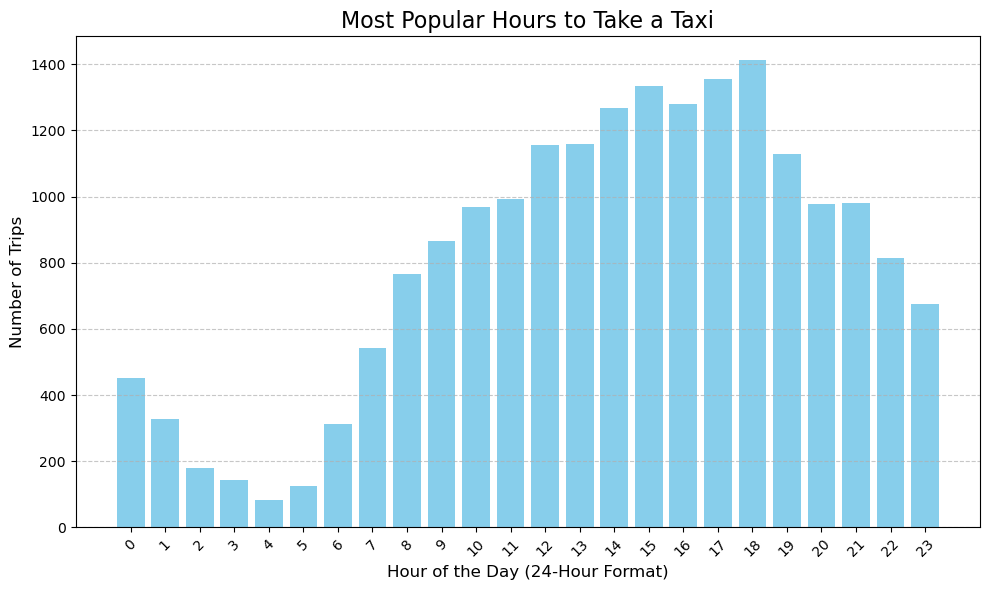

In [158]:
def visualize_popular_hour_to_take_taxi(engine):
    query = """
    SELECT 
        strftime('%H', pickup_datetime) AS hour,
        COUNT(*) AS trip_count
    FROM taxi_trips
    GROUP BY hour
    ORDER BY trip_count DESC;
    """
    with engine.connect() as conn:
        data = pd.read_sql(query, conn)

    # Convert hour to an integer for proper sorting
    data['hour'] = data['hour'].astype(int)

    # Sort by hour for a meaningful time series plot
    data = data.sort_values('hour')

    plt.figure(figsize=(10, 6))
    plt.bar(data['hour'], data['trip_count'], color='skyblue')
    plt.title("Most Popular Hours to Take a Taxi", fontsize=16)
    plt.xlabel("Hour of the Day (24-Hour Format)", fontsize=12)
    plt.ylabel("Number of Trips", fontsize=12)
    plt.xticks(data['hour'], rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
DATABASE_URL = "sqlite:///project.db"
engine = create_engine(DATABASE_URL)
visualize_popular_hour_to_take_taxi(engine)

### Visualization 2: What’s the most popular month to hire a cab or Uber?

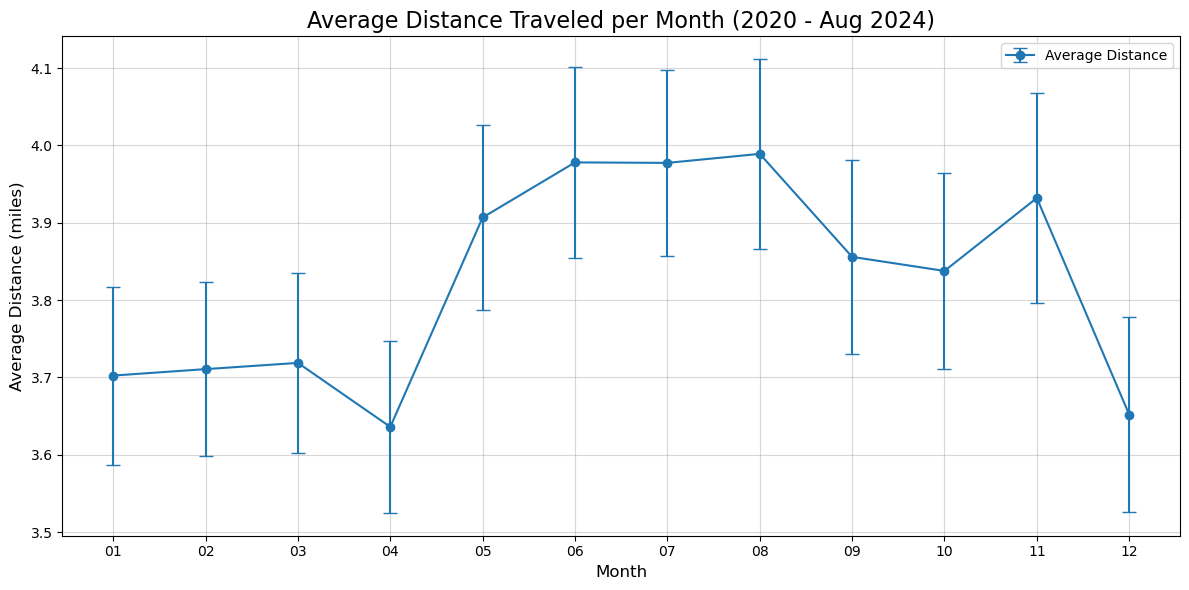

In [159]:
def fetch_monthly_distance_data(engine):
    """
    Fetch average distance traveled per month for both taxis and Ubers combined.

    Args:
        engine: SQLAlchemy engine connected to the database.
    
    Returns:
        DataFrame with average distance and 90% confidence intervals by month.
    """
    query = """
    SELECT 
        strftime('%m', pickup_datetime) AS month,
        trip_distance AS distance
    FROM taxi_trips
    UNION ALL
    SELECT 
        strftime('%m', pickup_datetime) AS month,
        trip_miles AS distance
    FROM uber_trips;
    """
    with engine.connect() as connection:
        data = pd.read_sql(query, connection)

    # Group by month and calculate statistics
    data["month"] = data["month"].astype(int)
    grouped = data.groupby("month")["distance"].agg(['mean', 'count', 'std']).reset_index()

    # Calculate 90% confidence interval
    grouped['ci'] = 1.645 * (grouped['std'] / np.sqrt(grouped['count']))
    grouped['month'] = grouped['month'].apply(lambda x: f"{x:02d}")  
    return grouped

def plot_average_distance_with_ci(data):
    """
    Plot the average distance traveled per month with 90% confidence intervals.

    Args:
        data: DataFrame with 'month', 'mean', and 'ci' columns.
    """
    data = data.sort_values(by="month")

    plt.figure(figsize=(12, 6))
    plt.errorbar(data['month'], data['mean'], yerr=data['ci'], fmt='o-', capsize=5, label='Average Distance')
    plt.title('Average Distance Traveled per Month (2020 - Aug 2024)', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Average Distance (miles)', fontsize=12)
    plt.xticks(data['month'], fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

DATABASE_URL = "sqlite:///project.db"
engine = create_engine(DATABASE_URL)
monthly_data = fetch_monthly_distance_data(engine)
plot_average_distance_with_ci(monthly_data)

### Visualization 3: Which day of the week is most popular for taking a ride to an NYC-based airport?

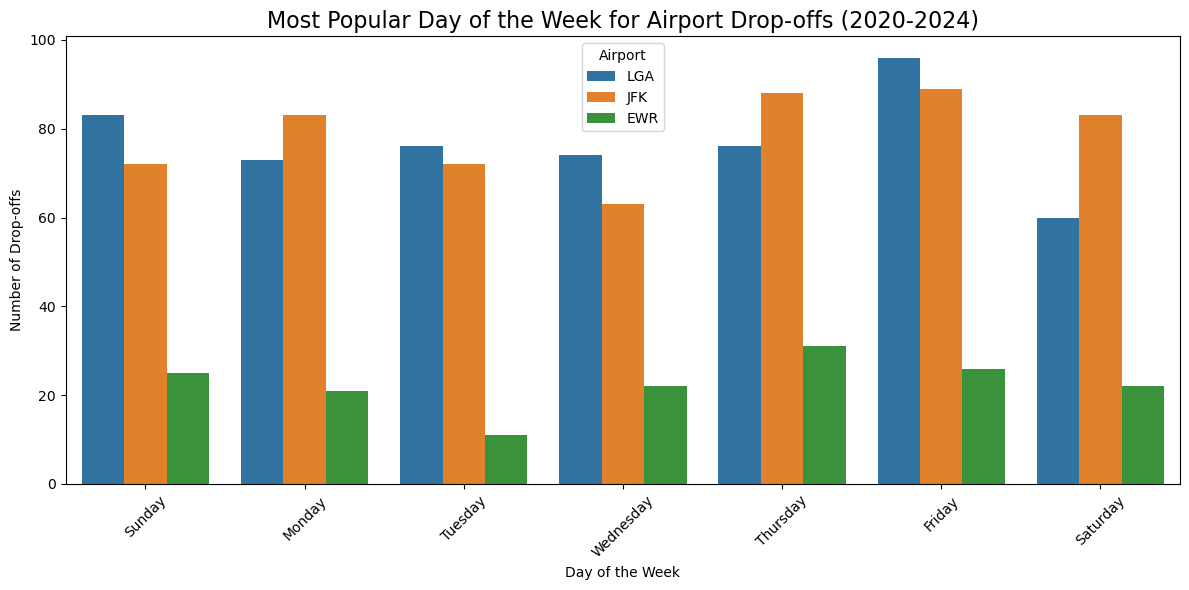

In [160]:
def fetch_airport_dropoff_data(engine, airport_coords):
    query_template = """
    SELECT 
        strftime('%w', dropoff_datetime) AS day_of_week,
        '{airport}' AS airport
    FROM {table}
    WHERE dropoff_latitude BETWEEN {lat_min} AND {lat_max}
      AND dropoff_longitude BETWEEN {lon_min} AND {lon_max}
      AND dropoff_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    """
    
    queries = []
    
    for airport, ((lat_min, lon_min), (lat_max, lon_max)) in airport_coords.items():
        for table in ['taxi_trips', 'uber_trips']:
            queries.append(query_template.format(
                airport=airport,
                table=table,
                lat_min=lat_min,
                lat_max=lat_max,
                lon_min=lon_min,
                lon_max=lon_max
            ))
    
    combined_query = " UNION ALL ".join(queries)
    
    try:
        with engine.connect() as connection:
            data = pd.read_sql(combined_query, connection)
        
        # Convert day_of_week to integers
        data['day_of_week'] = data['day_of_week'].astype(int)
        
        # Map day numbers to day names
        data['day_name'] = pd.Categorical(
            data['day_of_week'].replace({
                0: "Sunday", 1: "Monday", 2: "Tuesday", 3: "Wednesday",
                4: "Thursday", 5: "Friday", 6: "Saturday"
            }),
            categories=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"],
            ordered=True
        )
        
        return data
    
    except Exception as e:
        print(f"Error fetching airport dropoff data: {e}")
        return None

def plot_airport_popularity(data):
    if data is None or data.empty:
        print("No data available to plot.")
        return
    
    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=data,
        x="day_name",
        hue="airport",
        order=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
    )
    plt.title("Most Popular Day of the Week for Airport Drop-offs (2020-2024)", fontsize=16)
    plt.xlabel("Day of the Week")
    plt.ylabel("Number of Drop-offs")
    plt.legend(title="Airport")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

DATABASE_URL = "sqlite:///project.db"
engine = create_engine(DATABASE_URL)

AIRPORT_COORDS = {
    "LGA": ((40.763589, -73.891745), (40.778865, -73.854838)),
    "JFK": ((40.639263, -73.795642), (40.651376, -73.766264)),
    "EWR": ((40.686794, -74.194028), (40.699680, -74.165205)),
}
airport_data = fetch_airport_dropoff_data(engine, AIRPORT_COORDS)
plot_airport_popularity(airport_data)

### Visualization 4: How much do hired rides earn in total fares monthly?

In [161]:
def fetch_monthly_fare_data(engine):
    query = """
    SELECT 
        strftime('%Y-%m', pickup_datetime) AS month,
        'Yellow Taxi' AS ride_type,
        SUM(fare_amount) AS base_fare,
        SUM(mta_tax) AS taxes,
        SUM(congestion_surcharge) AS surcharges,
        SUM(tolls_amount) AS tolls,
        SUM(total_amount) AS total
    FROM taxi_trips
    GROUP BY month
    UNION ALL
    SELECT 
        strftime('%Y-%m', pickup_datetime) AS month,
        'Uber' AS ride_type,
        SUM(base_passenger_fare) AS base_fare,
        SUM(sales_tax) AS taxes,
        SUM(congestion_surcharge) AS surcharges,
        SUM(tolls) AS tolls,
        SUM(base_passenger_fare + sales_tax + congestion_surcharge + tolls + tips) AS total
    FROM uber_trips
    GROUP BY month
    ORDER BY month;
    """

    with engine.connect() as conn:
        data = pd.read_sql(query, conn)
        data['month'] = pd.to_datetime(data['month'])
    return data


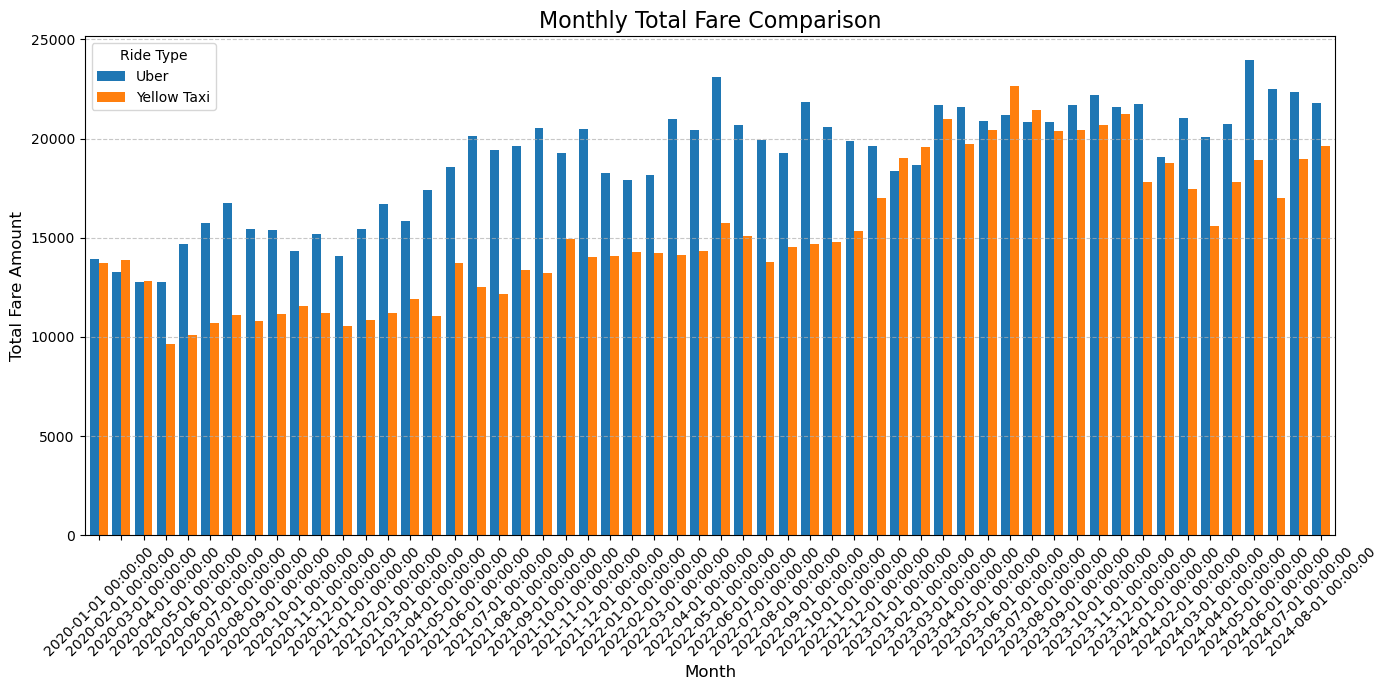

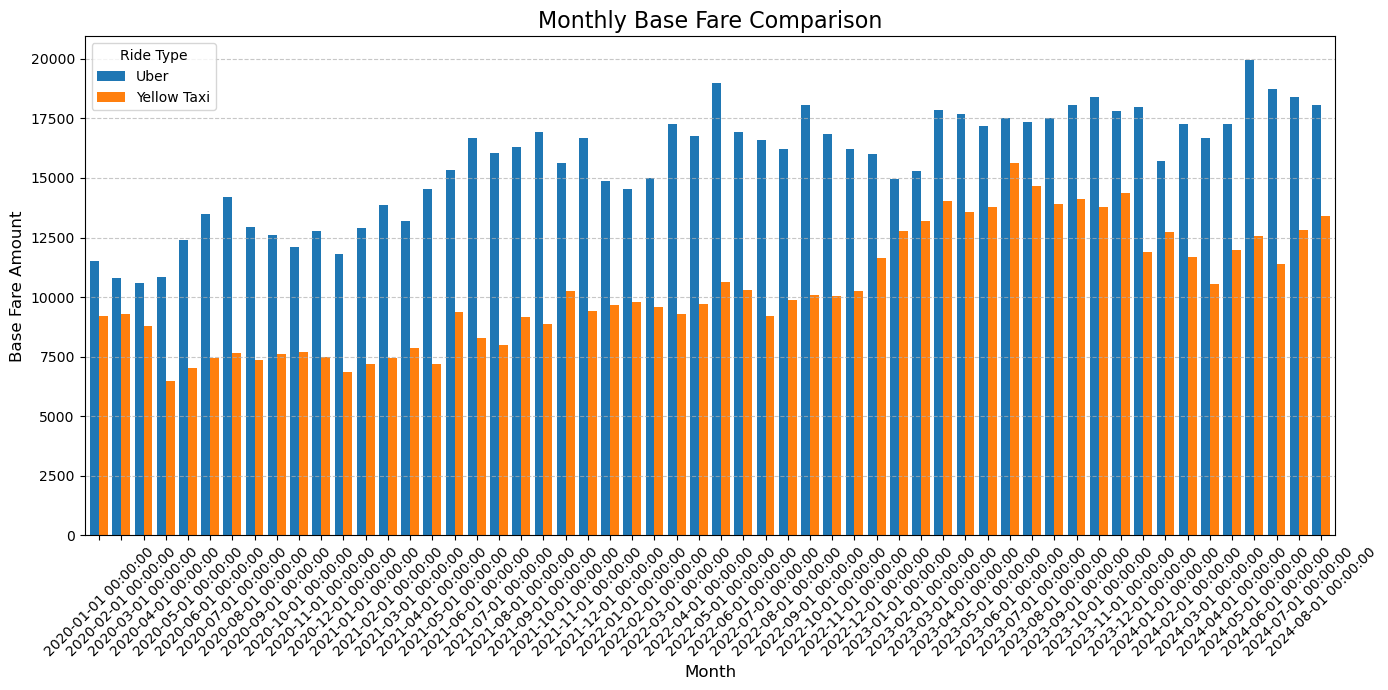

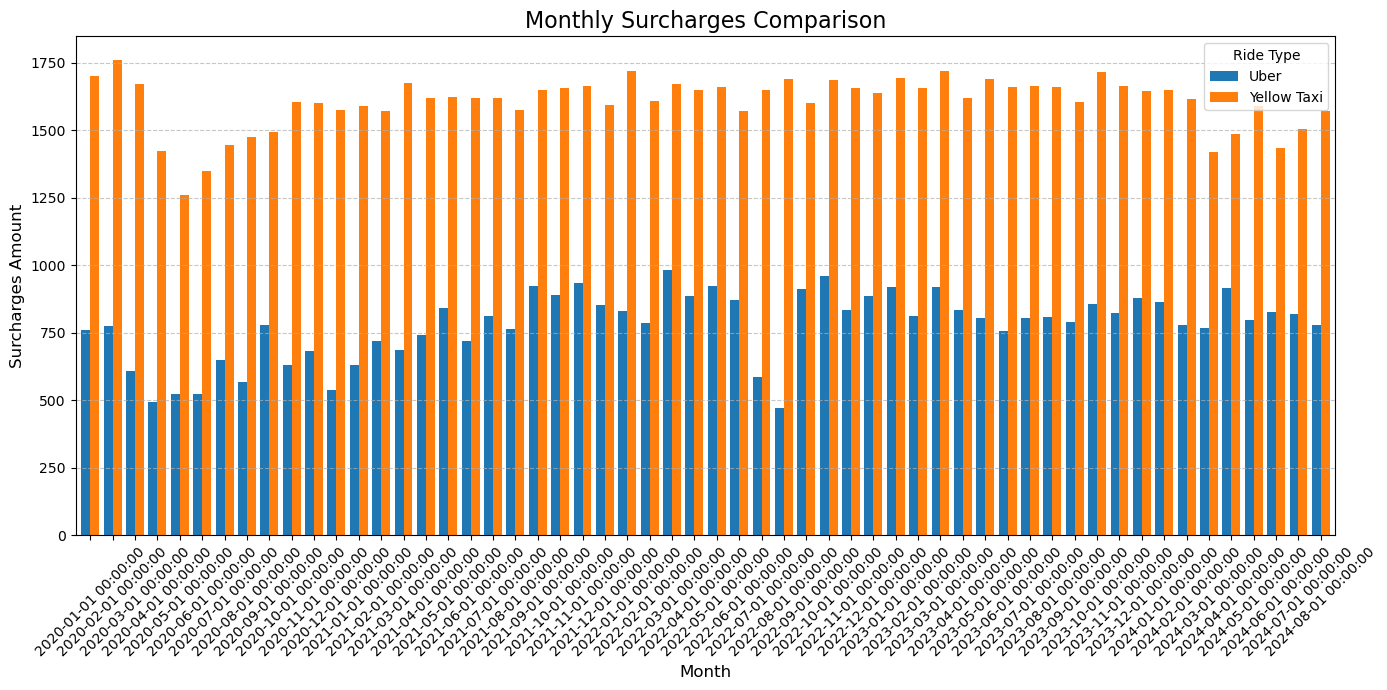

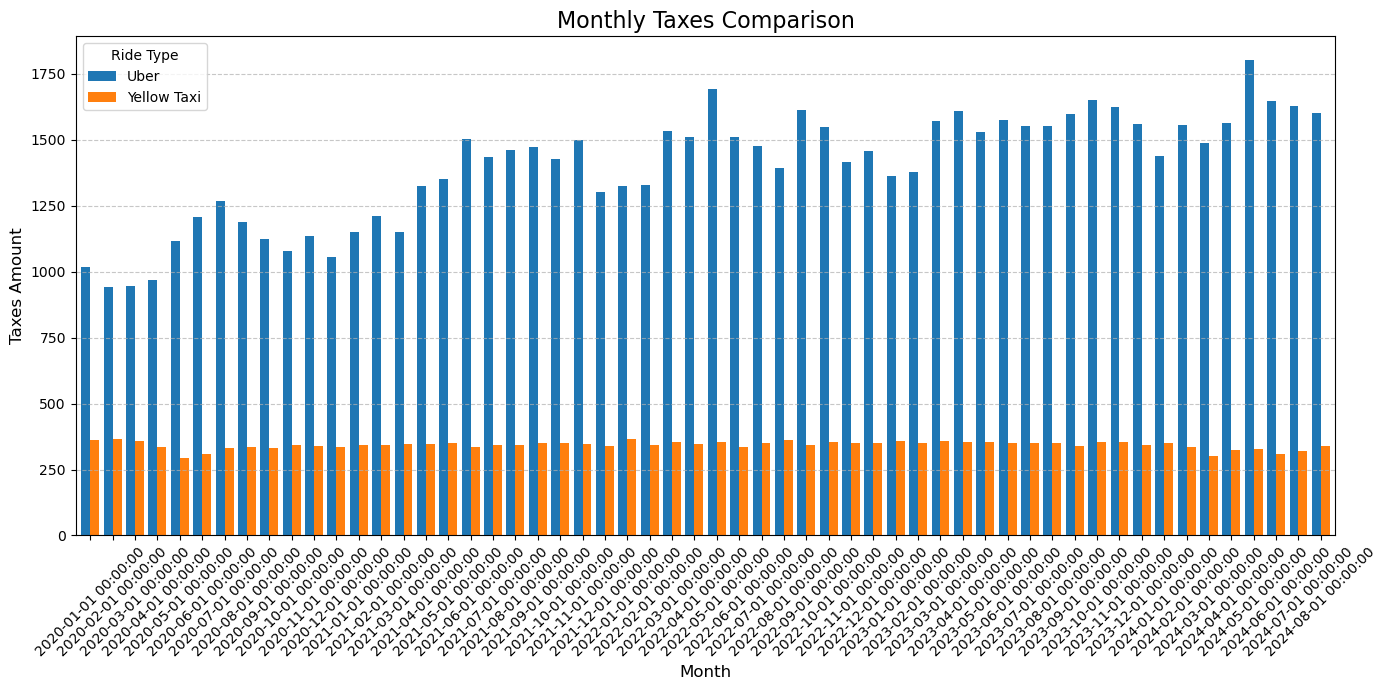

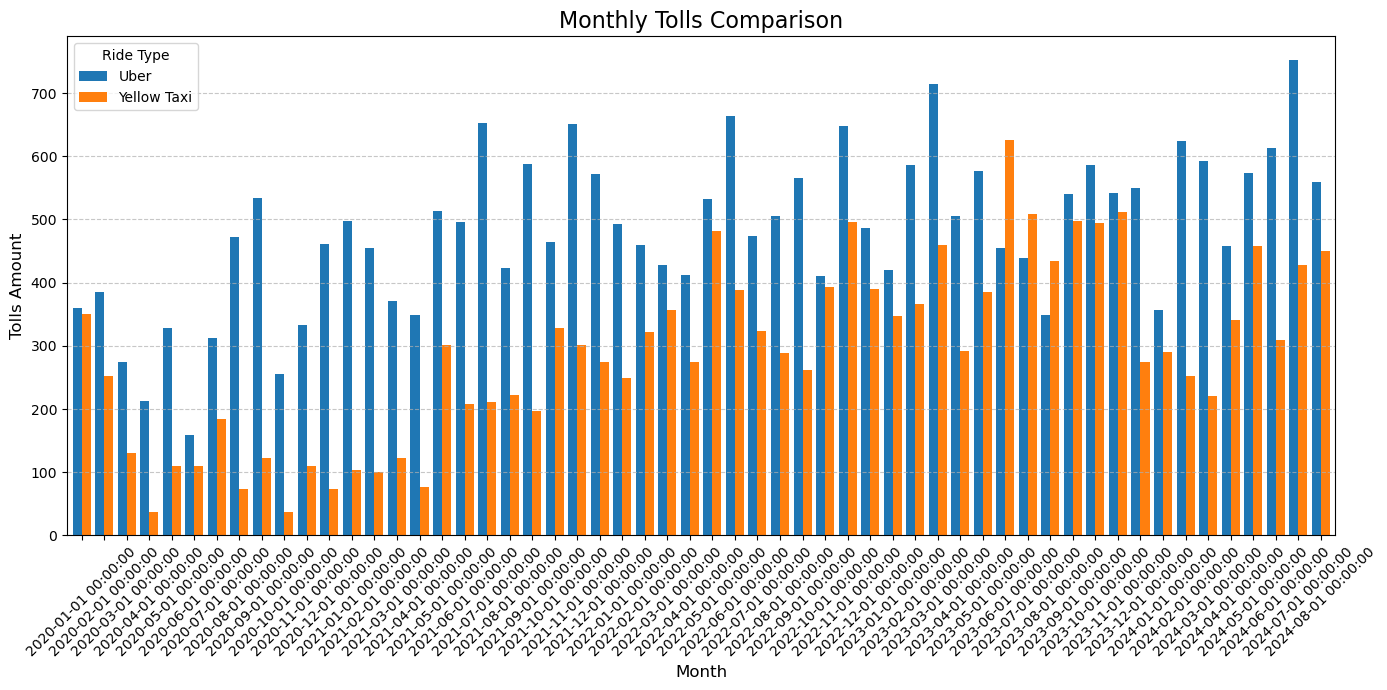

In [89]:
def plot_monthly_comparison(data):
    metrics = ['total', 'base_fare', 'surcharges', 'taxes', 'tolls']
    titles = ["Total Fare", "Base Fare", "Surcharges", "Taxes", "Tolls"]

    for metric, title in zip(metrics, titles):
        pivot_data = data.pivot(index='month', columns='ride_type', values=metric)
        pivot_data.plot(kind='bar', figsize=(14, 7), width=0.8)

        plt.title(f"Monthly {title} Comparison", fontsize=16)
        plt.xlabel("Month", fontsize=12)
        plt.ylabel(f"{title} Amount", fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(title="Ride Type")
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

DATABASE_URL = "sqlite:///project.db"
engine = create_engine(DATABASE_URL)
data = fetch_monthly_fare_data(engine)
plot_monthly_comparison(data)


### Visualization 5: Does precipitation or distance traveled affect the amount of tip?

In [169]:
# Database setup
DATABASE_URL = "sqlite:///project.db"
engine = create_engine(DATABASE_URL)

# Step 1: Inspect Daily Precipitation Data
def inspect_daily_precipitation_data():
    query = """
    SELECT date, daily_precipitation
    FROM daily_weather
    WHERE daily_precipitation IS NOT NULL
    LIMIT 10;
    """
    with engine.connect() as con:
        results = con.execute(text(query)).fetchall()
        print("Sample data from daily_weather (daily_precipitation):")
        for row in results:
            print(row)

inspect_daily_precipitation_data()

# Step 2: Validate Date Matching Between Trips and Daily Weather
def check_date_overlap():
    query = """
    SELECT DISTINCT DATE(pickup_datetime) AS trip_date
    FROM (
        SELECT pickup_datetime FROM taxi_trips
        UNION ALL
        SELECT pickup_datetime FROM uber_trips
    ) trips
    WHERE DATE(pickup_datetime) NOT IN (SELECT date FROM daily_weather);
    """
    with engine.connect() as con:
        results = con.execute(text(query)).fetchall()
        for row in results:
            print(row)

check_date_overlap()

# Step 3: Fetch Tip, Distance, and Precipitation Data
def fetch_tip_distance_precipitation_data(engine):
    query = """
    SELECT
        t.tip_amount AS tip_amount,
        t.trip_distance AS distance,
        COALESCE(dw.daily_precipitation, 0) AS precipitation,
        'Yellow Taxi' AS ride_type
    FROM taxi_trips t
    LEFT JOIN daily_weather dw
    ON DATE(t.pickup_datetime) = dw.date
    WHERE strftime('%Y', t.pickup_datetime) IN ('2022', '2023')

    UNION ALL

    SELECT
        u.tips AS tip_amount,
        u.trip_miles AS distance,
        COALESCE(dw.daily_precipitation, 0) AS precipitation,
        'Uber' AS ride_type
    FROM uber_trips u
    LEFT JOIN daily_weather dw
    ON DATE(u.pickup_datetime) = dw.date
    WHERE strftime('%Y', u.pickup_datetime) IN ('2022', '2023')
    """
    with engine.connect() as conn:
        return pd.read_sql(query, conn)

data = fetch_tip_distance_precipitation_data(engine)


Sample data from daily_weather (daily_precipitation):
('2020-01-01 00:00:00.000000', 0.0097073116854429)
('2020-01-02 00:00:00.000000', 0.2038535453943009)
('2020-01-03 00:00:00.000000', 0.3167804285398719)
('2020-01-04 00:00:00.000000', 0.8429754804506296)
('2020-01-05 00:00:00.000000', 0.0291219350563287)
('2020-01-06 00:00:00.000000', 0.30385354539430093)
('2020-01-07 00:00:00.000000', 0.0388292467417716)
('2020-01-08 00:00:00.000000', 0.06795118179810031)
('2020-01-09 00:00:00.000000', 0.0097073116854429)
('2020-01-10 00:00:00.000000', 0.0582438701126574)
('2020-01-25',)
('2020-01-15',)
('2020-01-09',)
('2020-01-26',)
('2020-01-30',)
('2020-01-29',)
('2020-01-27',)
('2020-01-12',)
('2020-01-17',)
('2020-01-24',)
('2020-01-21',)
('2020-01-18',)
('2020-01-22',)
('2020-01-23',)
('2020-01-07',)
('2020-01-28',)
('2020-01-01',)
('2020-01-05',)
('2020-01-02',)
('2020-01-06',)
('2020-01-20',)
('2020-01-08',)
('2020-01-10',)
('2020-01-19',)
('2020-01-14',)
('2020-01-13',)
('2020-01-04',)
('

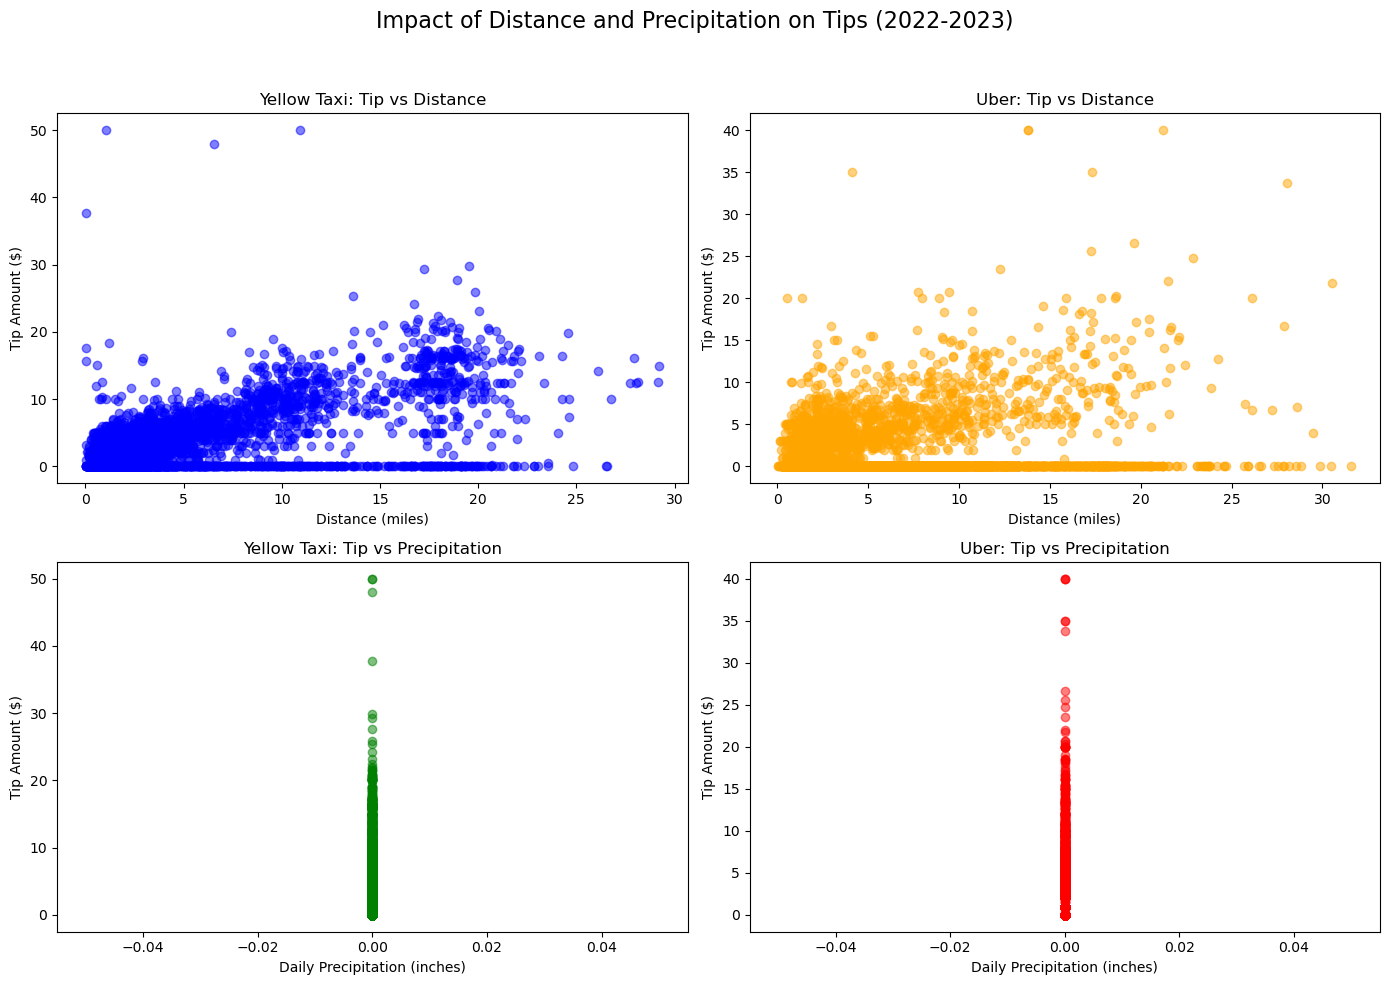

In [171]:
# Step 4: Plot Relationships
def plot_tip_relationships(data):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)
    fig.suptitle("Impact of Distance and Precipitation on Tips (2022-2023)", fontsize=16)

    # Filter data for Yellow Taxi and Uber
    yellow_taxi_data = data[data['ride_type'] == 'Yellow Taxi']
    uber_data = data[data['ride_type'] == 'Uber']

    # Scatter plot for Yellow Taxi Tip vs Distance
    axes[0, 0].scatter(yellow_taxi_data['distance'], yellow_taxi_data['tip_amount'], alpha=0.5, c='blue')
    axes[0, 0].set_title("Yellow Taxi: Tip vs Distance")
    axes[0, 0].set_xlabel("Distance (miles)")
    axes[0, 0].set_ylabel("Tip Amount ($)")

    # Scatter plot for Uber Tip vs Distance
    axes[0, 1].scatter(uber_data['distance'], uber_data['tip_amount'], alpha=0.5, c='orange')
    axes[0, 1].set_title("Uber: Tip vs Distance")
    axes[0, 1].set_xlabel("Distance (miles)")
    axes[0, 1].set_ylabel("Tip Amount ($)")

    # Scatter plot for Yellow Taxi Tip vs Precipitation
    axes[1, 0].scatter(yellow_taxi_data['precipitation'], yellow_taxi_data['tip_amount'], alpha=0.5, c='green')
    axes[1, 0].set_title("Yellow Taxi: Tip vs Precipitation")
    axes[1, 0].set_xlabel("Daily Precipitation (inches)")
    axes[1, 0].set_ylabel("Tip Amount ($)")

    # Scatter plot for Uber Tip vs Precipitation
    axes[1, 1].scatter(uber_data['precipitation'], uber_data['tip_amount'], alpha=0.5, c='red')
    axes[1, 1].set_title("Uber: Tip vs Precipitation")
    axes[1, 1].set_xlabel("Daily Precipitation (inches)")
    axes[1, 1].set_ylabel("Tip Amount ($)")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_tip_relationships(data)

### Visualization 6: Create a heatmap of all hired trips in 2020 over a map of the area

In [59]:
def visualize_heatmap(database_url, year="2020"):
    """
    Generates and visualizes a heatmap for all hired trips in a given year.

    Args:
        database_url (str): The URL of the database.
        year (str): The year for which the heatmap will be generated.
    """
    engine = create_engine(database_url)
    query = f"""
    SELECT 
        pickup_latitude AS lat,
        pickup_longitude AS lon
    FROM taxi_trips
    WHERE strftime('%Y', pickup_datetime) = '{year}'
    UNION ALL
    SELECT 
        pickup_latitude AS lat,
        pickup_longitude AS lon
    FROM uber_trips
    WHERE strftime('%Y', pickup_datetime) = '{year}';
    """

    with engine.connect() as connection:
        trip_data = pd.read_sql(query, connection)

    # Drop rows with missing or invalid coordinates
    trip_data = trip_data.dropna(subset=["lat", "lon"])
    trip_data = trip_data[(trip_data["lat"] != 0) & (trip_data["lon"] != 0)]

    nyc_center = [40.7128, -74.0060]  # Center of NYC
    m = folium.Map(location=nyc_center, zoom_start=12)

    heat_data = trip_data[["lat", "lon"]].values.tolist()
    HeatMap(heat_data, radius=8).add_to(m)
    return m

# Example usage
DATABASE_URL = "sqlite:///project.db"
heatmap = visualize_heatmap(DATABASE_URL, year="2020")
heatmap


### Extra question: Sunrise and Sunset dataset 
### What is the average trip distance for taxi trips starting before sunrise and those starting after sunset, grouped by each day of the week?

In [165]:
QUERY_FILENAME = "average_trip_distance_sunrise_sunset.sql"

QUERY = """
WITH SunriseSunsetTrips AS (
    SELECT 
        tt.trip_distance,
        strftime('%w', tt.pickup_datetime) AS day_of_week,
        CASE 
            WHEN strftime('%H:%M', tt.pickup_datetime) < ss.sunrise THEN 'Before Sunrise'
            WHEN strftime('%H:%M', tt.pickup_datetime) > ss.sunset THEN 'After Sunset'
            ELSE 'Daytime'
        END AS time_period
    FROM 
        taxi_trips tt
    JOIN 
        sunrise_sunset ss
    ON 
        DATE(tt.pickup_datetime) = ss.date
)
SELECT 
    day_of_week,
    time_period,
    AVG(trip_distance) AS avg_trip_distance
FROM 
    SunriseSunsetTrips
WHERE 
    time_period IN ('Before Sunrise', 'After Sunset')
GROUP BY 
    day_of_week, time_period
ORDER BY 
    day_of_week, time_period;
"""

write_query_to_file(QUERY, QUERY_FILENAME)

with engine.connect() as con:
    result = con.execute(text(QUERY)).fetchall()
    print("Average Trip Distance Before Sunrise and After Sunset, Grouped by Day of the Week:")
    for row in result:
        print(f"Day: {row[0]}, Time Period: {row[1]}, Avg Trip Distance: {row[2]:.2f}")

Average Trip Distance Before Sunrise and After Sunset, Grouped by Day of the Week:
Day: 0, Time Period: After Sunset, Avg Trip Distance: 3.42
Day: 1, Time Period: After Sunset, Avg Trip Distance: 3.37
Day: 2, Time Period: After Sunset, Avg Trip Distance: 3.08
Day: 3, Time Period: After Sunset, Avg Trip Distance: 3.03
Day: 4, Time Period: After Sunset, Avg Trip Distance: 3.07
Day: 5, Time Period: After Sunset, Avg Trip Distance: 3.12
Day: 6, Time Period: After Sunset, Avg Trip Distance: 3.23
